# Building SolveIt in SolveIt

I give you a challenge: can you build SolveIt in SolveIt in SolveIt?

Salman Naqvi  
Thursday, 22 January 2026

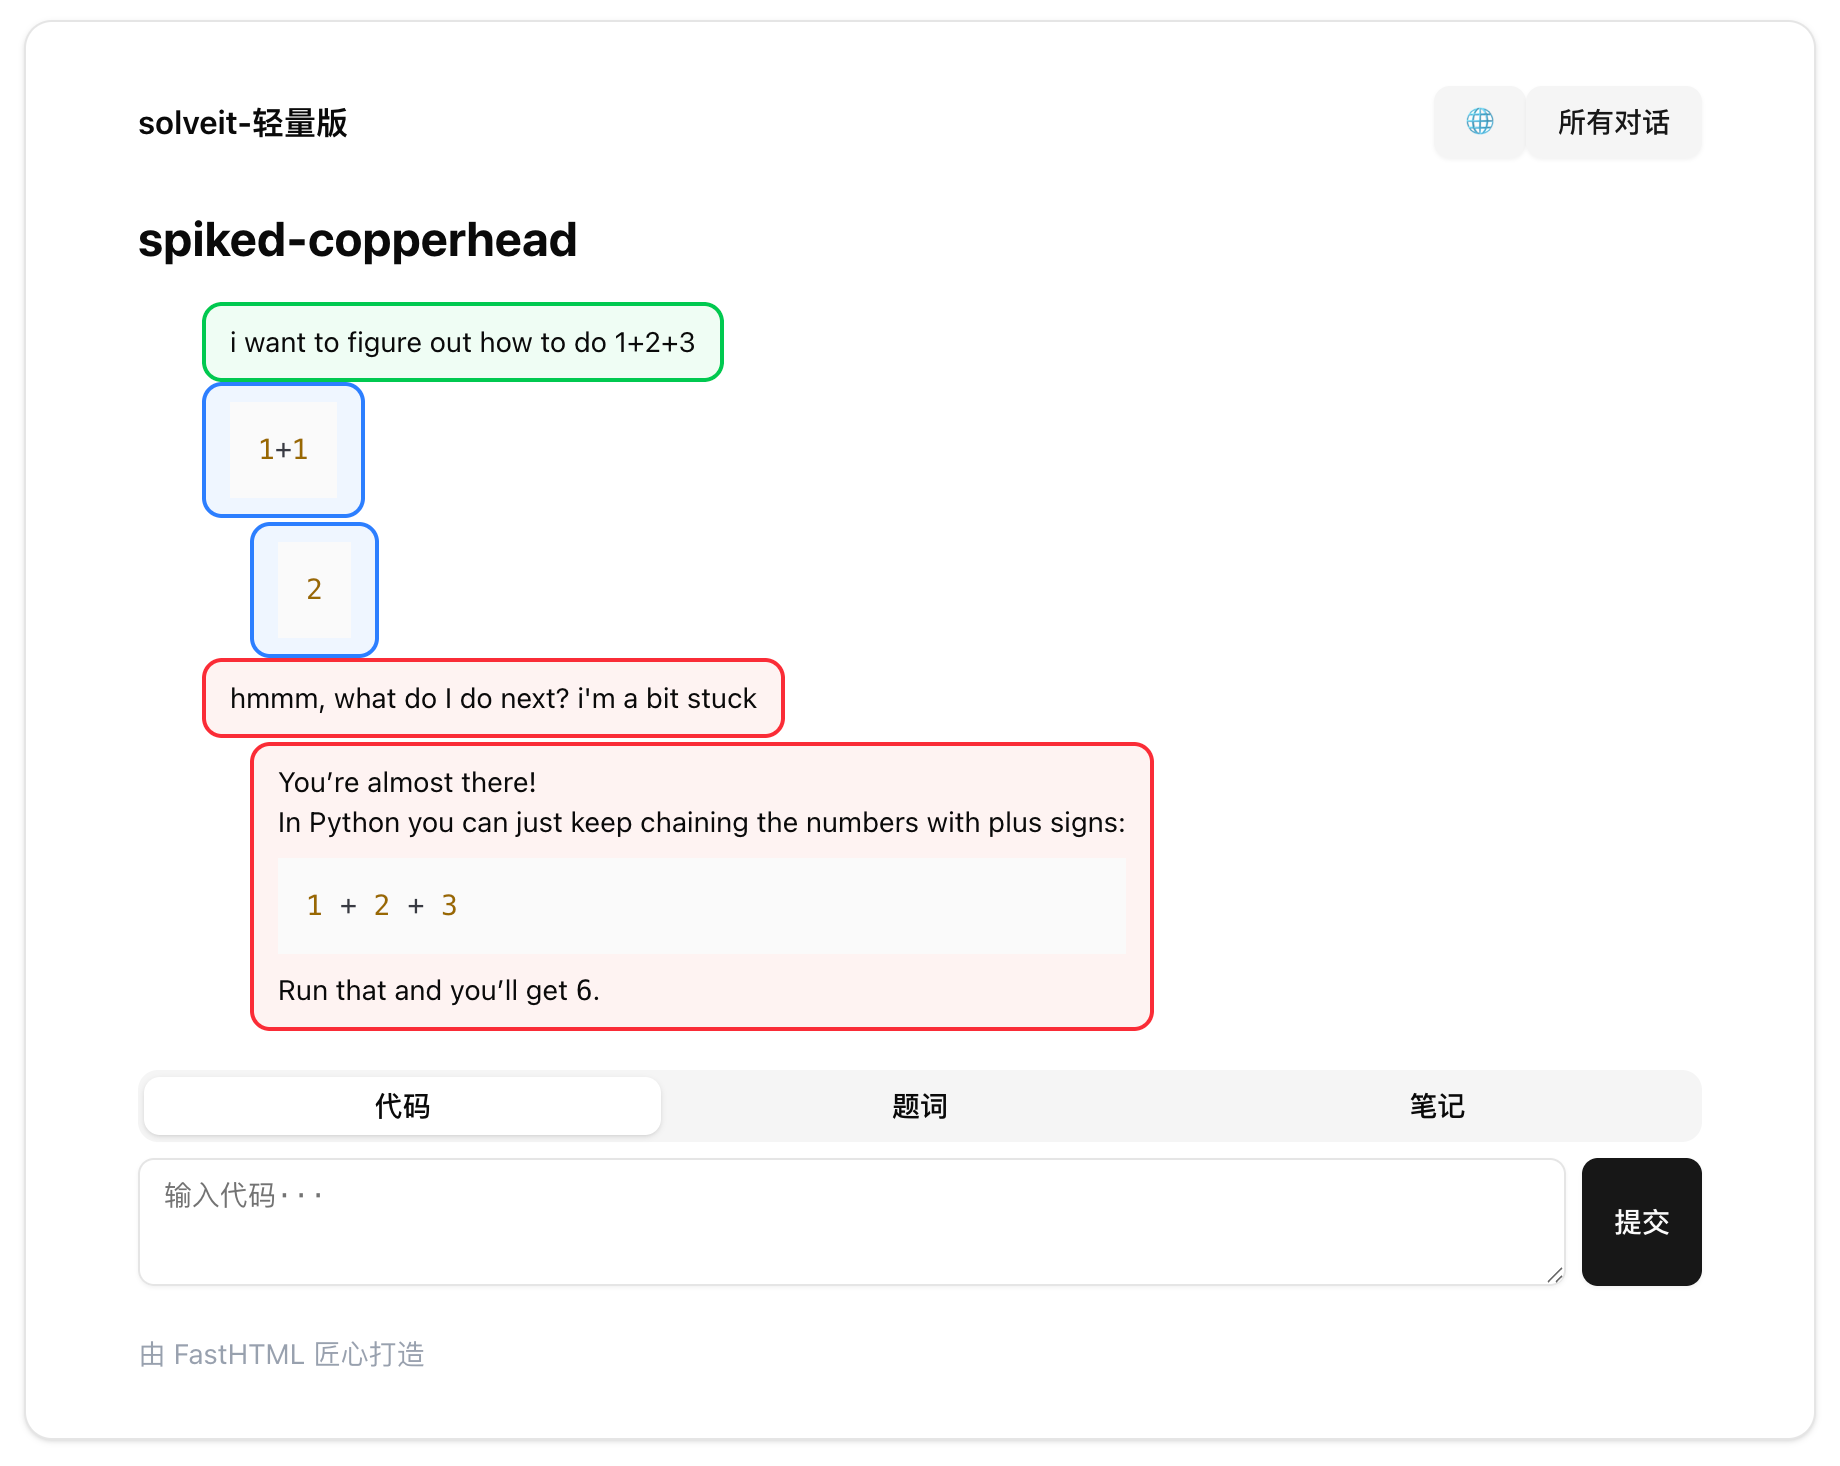

> **Note**
>
> This app is built on the techniques taught in Lessons 4, 5, and 6 of
> the SolveIt course led by [Jeremy
> Howard](https://solve.it.com/#im-jeremy-howard-from-fastai) who
> created the first modern LLM in 2018, and [Johnothan
> Whitaker](https://www.johnowhitaker.com/). SolveIt is also a brilliant
> problem-solving framework and interactive platform, that puts you in
> control–not the LLM.
>
> Also thanks to [Rens Dimmendaal](https://rensdimmendaal.com/) for [his
> dialog](https://share.solve.it.com/d/5426704f61ba89b1ae547d6506929da7)
> on how to deploy an app to [Plash](https://pla.sh/) from SolveIt.

This blog post is a rendered documentation of a very, very basic
reimplementation of [SolveIt](solve.it.com) using FastHTML as the web
framework. The main goal of this exercise was to exercise my web
development and HTMX skillz. Play with the app [at this
link](https://solveit-lite-unofficial.pla.sh/). Or watch the brief
overview below.

<iframe src="https://cap.so/embed/k9xxnxzyfa19fms" frameborder="0" webkitallowfullscreen mozallowfullscreen allowfullscreen style="position: absolute; top: 0; left: 0; width: 100%; height: 100%;">

</iframe>

SolveIt is an IDE of sorts that’s not only tailored towards coding, but
a variety of other tasks from writing to problem solving to planning to
learning to exploring and what not. Its premise revolves around the LLM
putting the human in control, and thereby boosting human performance and
capability. A core part of why SolveIt works so well is that your work
*is* the LLM context.

Many parts of this app can still be improved, refactored, or made more
efficient. Play with the app [at this
link](https://solveit-lite-unofficial.pla.sh/).

Features include:

-   Code/LLM/Note cells
-   Context aware LLM
-   Restore functionality
-   Create multiple dialogs
-   Rename dialogs
-   Chinese/English localization

> **Note**
>
> Certain FastHTML components of my app have been directly rendered as a
> part of this page. The FastHTML routes have not been and have been
> displayed as an image–these would otherwise be rendered in a Jupyter
> Notebook.

### Settings and Headers

In [ ]:
from fasthtml.common import *

In [ ]:
bsc_hdrs = (
    Script(src="https://cdn.jsdelivr.net/npm/@tailwindcss/browser@4"),  # Need to download first.
    Link(rel='stylesheet', href='https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/basecoat.cdn.min.css'),
    Script(src='https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/js/all.min.js', defer=True),
)

In [ ]:
app = FastHTML(hdrs=(bsc_hdrs, MarkdownJS(), HighlightJS(langs=['python'])), session_cookie='mysessioncookie', debug=True)
rt = app.route

A custom session cookie needs to be set for FastHTML sessions to work in
SolveIt as SolveIt currently uses the default one.

### Preview

Here I create a preview helper function that will allow me to
interactively preview various components of the app.

In [ ]:
from functools import partial
from fasthtml.jupyter import *

In [ ]:
server = JupyUvi(app)

In [ ]:
def get_preview(app):
    return partial(HTMX, app=app, host=None, port=None)
prev = get_preview(app); prev()

<iframe src="/" style="width: 100%; height: auto; border: none;" onload="{
 let frame = this;
 window.addEventListener('message', function(e) {
 if (e.source !== frame.contentWindow) return; // Only proceed if the message is from this iframe
 if (e.data.height) frame.style.height = (e.data.height+1) + 'px';
 }, false);
 }" allow="accelerometer; autoplay; camera; clipboard-read; clipboard-write; display-capture; encrypted-media; fullscreen; gamepad; geolocation; gyroscope; hid; identity-credentials-get; idle-detection; magnetometer; microphone; midi; payment; picture-in-picture; publickey-credentials-get; screen-wake-lock; serial; usb; web-share; xr-spatial-tracking">

In [ ]:
render_ft()

`render_ft` will render any output FastHTML. `prev` will display it in
the context of the FastHTML app.

### Database

Creating a database to store users and their dialogs, with dialogs
linked to users via `uid`.

In [ ]:
from fastlite import *

In [ ]:
db = database('solvish.db')

In [ ]:
db

<Database <apsw.Connection object "/app/data/forbo7.github.io/forblog/posts/solvish.db" at 0x70ee23760500>>

In [ ]:
class User: id:int; restore_code:str
class Dialog: id:int; uid:int; dialog_num:int; name:str; messages:str; server_session:str

In [ ]:
users = db.create(User, transform=True)
dialogs = db.create(Dialog, pk=('uid', 'dialog_num'), transform=True)

Tables will not be overwritten as `db.create()` is idempotent.

In [ ]:
users.delete_where()
dialogs.delete_where()

<Table dialog (id, uid, dialog_num, name, messages, server_session)>

`.delete_where` with no arguments passed will drop all rows from the
table.

### New Dialog

Creating a new dialog first auto-increments `dialog_num` based on the
user’s existing dialogs, then sets `session['current_dialog']` to track
which dialog is active. The dialog is stored in the `dialogs` table for
persistence across sessions, while also being loaded into `user_chats`
as a live chat object for the current server session.

In [ ]:
from lisette.core import *
from toolslm.shell import get_shell

sp = 'Respond in the language the user uses; The user has access to a Python interpreter that you can view; NEVER copy the format of the code interpreter messsages in your response.'
def make_chat(hist=[]): return Chat('moonshot/kimi-k2-0711-preview', hist=hist, sp=sp), get_shell()

In [ ]:
make_chat()

(<lisette.core.Chat at 0x70ee1a849eb0>,
 <IPython.terminal.interactiveshell.TerminalInteractiveShell at 0x70ee1a849f40>)

As my Kimi API key is compatable with servers in China, I have to change
the Moonshoot endpoint.

In [ ]:
os.environ['MOONSHOT_API_BASE'] = 'https://api.moonshot.cn/v1'

In [ ]:
# from cachy import enable_cachy; enable_cachy()

[cachy](https://github.com/AnswerDotAI/cachy) will cache my API calls.

In [ ]:
make_chat()[0]('what do you have access to?')

In [ ]:
from coolname import generate_slug

@rt
def create_dialog(session):
    uid = session.get('userid')
    existing = dialogs(where=f'uid={uid}')
    dnum = max((d.dialog_num for d in existing), default=0) + 1
    session['current_dialog'] = dnum
    dialogs.insert(uid=uid, dialog_num=dnum, name=generate_slug(2), messages='[]')
    user_chats[(uid,dnum)] = make_chat()
    return Div(hx_get=f'/dialog?dnum={dnum}', hx_trigger='load', hx_target='#content', hx_swap='innerHTML')

### Session Persistance

In [ ]:
user_chats = {}


I’ll be handling session persistance with this `user_chats` dictionary.
If my server restarts, it means `user_chats` will be erased and thus a
new session will be created for all users. Users can input their restore
code to retrieve back their data.

In [ ]:
def ensure_user(session):
    uid = session.get('userid')
    if not uid or uid not in users:
        u = users.insert(restore_code=generate_slug(3))
        session['userid'] = u.id
    return session['userid']

In [ ]:
fake_session = {}

In [ ]:
uid = ensure_user(fake_session)
fake_session, uid

({'userid': 1}, 1)

In [ ]:
from fastcore.all import *
import json

def ensure_dialog(session):
    uid, dnum = map(session.get, ('userid', 'current_dialog'))
    if (uid, dnum) in user_chats: return
    elif dnum and (uid, dnum) in dialogs: 
        d = dialogs[(uid, dnum)]
        user_chats[(uid, dnum)] = make_chat(json.loads(d.messages))
    else: create_dialog(session)


`ensure_dialog` acts as a lazy loader for chat sessions. It first checks
whether the user’s current dialog is already active in memory—if so,
there’s nothing to do. If the dialog exists in the database but hasn’t
been loaded yet, it retrieves the stored messages and reconstructs the
chat object. Otherwise, when no dialog exists at all, it creates a fresh
one for the user.

In [ ]:
ensure_dialog(fake_session)
user_chats

{(1, 1): (<lisette.core.Chat at 0x70ee1a6efda0>,
  <IPython.terminal.interactiveshell.TerminalInteractiveShell at 0x70ee225f31a0>)}

In [ ]:
from contextvars import ContextVar
current_lang = ContextVar('lang', default='en'); current_lang

<ContextVar name='lang' default='en' at 0x70ee19141df0>

Every time a request is made, a new `ContextVar` is created. This is a
way I can keep language preferences seperate for each user.

In [ ]:
@rt
def setsession(session):
    current_lang.set(session.setdefault('lang', 'en'))
    uid = ensure_user(session)
    ensure_dialog(session)

In [ ]:
prev(setsession)

<iframe src="/setsession" style="width: 100%; height: auto; border: none;" onload="{
 let frame = this;
 window.addEventListener('message', function(e) {
 if (e.source !== frame.contentWindow) return; // Only proceed if the message is from this iframe
 if (e.data.height) frame.style.height = (e.data.height+1) + 'px';
 }, false);
 }" allow="accelerometer; autoplay; camera; clipboard-read; clipboard-write; display-capture; encrypted-media; fullscreen; gamepad; geolocation; gyroscope; hid; identity-credentials-get; idle-detection; magnetometer; microphone; midi; payment; picture-in-picture; publickey-credentials-get; screen-wake-lock; serial; usb; web-share; xr-spatial-tracking">

The cookie only stores the user id. The data for the user is stored
inside the current Python runtime. Once the runtime ends, the data is
lost. The database permanently stores everything.

In [ ]:
users()

[User(id=1, restore_code='provocative-lori-of-acceptance')]

In [ ]:
dialogs()

[Dialog(id=None, uid=1, dialog_num=1, name='viridian-pegasus', messages='[]', server_session=None)]

In [ ]:
user_chats

{(1, 1): (<lisette.core.Chat at 0x70ee1a6efda0>,
  <IPython.terminal.interactiveshell.TerminalInteractiveShell at 0x70ee225f31a0>)}

In [ ]:
@rt
def debug(session):
    return Pre(str(dict(session)))
prev(debug)

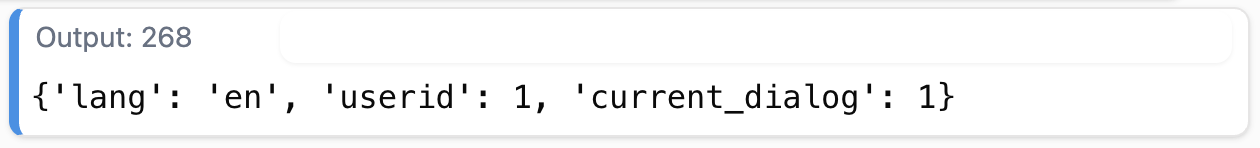

In [ ]:
@rt
def reset(session):
    session.clear()
    users.delete_where()
    dialogs.delete_where()
    return session

I won’t be exporting these two routes into the final application, else
it’d allow users to mess around with other users!

### Localization

A translation dictionary stores the strings for both Chinese and
English. The helper function `t()` performs the localization.

In [ ]:
T = {
    'zh': {
        'input_placeholder': '输入内容···',
        'submit': '提交',
        'ask_model': '问问模型···',
        'your_code': '你的代码···',
        'any_thoughts': '有啥想法···',
        'enter_code': '输入代码···',
        'code': '代码',
        'prompt': '题词',
        'note': '笔记',
        'tab': '标签',
        'all_dialogs': '所有对话',
        'new_dialog': '新对话',
        'delete': '删除',
        'save': '保存',
        'solveit_lite': 'solveit-轻量版',
        'footer': '由 FastHTML 匠心打造',
        'restore_code': '恢复码',
        'restore_failed': '‼ 恢复失败',
        'restore_error': '找不到与此恢复码关联的账户，请检查后重试。',
        'enter_restore_code': '输入恢复码···',
    },
    'en': {
        'input_placeholder': 'Enter content...',
        'submit': 'Submit',
        'ask_model': 'Ask the model...',
        'your_code': 'Your code...',
        'any_thoughts': 'Any thoughts...',
        'enter_code': 'Enter code...',
        'code': 'Code',
        'prompt': 'Prompt',
        'note': 'Note',
        'tab': 'Tab',
        'all_dialogs': 'All Dialogs',
        'new_dialog': 'New Dialog',
        'delete': 'Delete',
        'save': 'Save',
        'solveit_lite': 'solveit-lite',
        'footer': 'Crafted with FastHTML',
        'restore_code': 'Restore Code',
        'restore_failed': '‼ Restore Failed',
        'restore_error': 'No account found with this restore code. Please check and try again.',
        'enter_restore_code': 'Enter restore code...',
    }
}

In [ ]:
def t(key, session=None): 
    lang = session.get('lang', 'zh') if session else current_lang.get()
    return T[lang].get(key, key)

In [ ]:
t('ask_model', {'lang':'zh'})

'问问模型···'

### Chat Bubbles

Bubbles that display the dialog content. Each bubble type has its own
color scheme—blue for code, red for prompts, and green for notes.

In [ ]:
def Bubble(text, color, type='q', marked=True):
    colors = {
        'code': 'border-blue-500 bg-blue-50',
        'note': 'border-green-500 bg-green-50',
        'prompt': 'border-red-500 bg-red-50'
    }
    cls = f"{'marked' if marked else ''} {'ml-6' if type=='r' else ''} flex w-max max-w-[75%] flex-col gap-2 rounded-lg px-3 py-2 text-sm border-2 {colors[color]}"
    return Div(text, cls=cls)

In [ ]:
prev(Bubble('**嗨喽**', 'note'))

<iframe srcdoc=" <!doctype html>
 <html>
 <head>
 <title>FastHTML page</title>
 <link rel="canonical" href="https://testserver/_34x6U4i3QgWOfs8gF0Af-A">
 <meta charset="utf-8">
 <meta name="viewport" content="width=device-width, initial-scale=1, viewport-fit=cover">
<script src="https://cdn.jsdelivr.net/npm/htmx.org@2.0.7/dist/htmx.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/fasthtml-js@1.0.12/fasthtml.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/surreal@main/surreal.js"></script><script src="https://cdn.jsdelivr.net/gh/gnat/css-scope-inline@main/script.js"></script><script src="https://cdn.jsdelivr.net/npm/@tailwindcss/browser@4"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/basecoat.cdn.min.css">
<script src="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/js/all.min.js" defer></script><script type="module">import { marked } from "https://cdn.jsdelivr.net/npm/marked/lib/marked.esm.js";
proc_htmx('.marked', e => e.innerHTML = marked.parse(e.textContent));</script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-dark.css" media="(prefers-color-scheme: dark)">
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-light.css" media="(prefers-color-scheme: light)">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/highlight.min.js"></script><script src="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.js"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.css">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/languages/python.min.js"></script><script type="module">
hljs.addPlugin(new CopyButtonPlugin());
hljs.configure({'cssSelector': 'pre code:not([data-highlighted="yes"])'});
htmx.onLoad(hljs.highlightAll);</script><script>
 function sendmsg() {
 window.parent.postMessage({height: document.documentElement.offsetHeight}, '*');
 }
 window.onload = function() {
 sendmsg();
 document.body.addEventListener('htmx:afterSettle', sendmsg);
 document.body.addEventListener('htmx:wsAfterMessage', sendmsg);
 };</script> </head>
 <body>
 <div class="marked flex w-max max-w-[75%] flex-col gap-2 rounded-lg px-3 py-2 text-sm border-2 border-green-500 bg-green-50">**嗨喽**</div>
 </body>
 </html>
" style="width: 100%; height: auto; border: none;" onload="{
 let frame = this;
 window.addEventListener('message', function(e) {
 if (e.source !== frame.contentWindow) return; // Only proceed if the message is from this iframe
 if (e.data.height) frame.style.height = (e.data.height+1) + 'px';
 }, false);
 }" allow="accelerometer; autoplay; camera; clipboard-read; clipboard-write; display-capture; encrypted-media; fullscreen; gamepad; geolocation; gyroscope; hid; identity-credentials-get; idle-detection; magnetometer; microphone; midi; payment; picture-in-picture; publickey-credentials-get; screen-wake-lock; serial; usb; web-share; xr-spatial-tracking">

In [ ]:
prev(Div(
    Bubble('嗨！', 'prompt'),
    Bubble('哈喽！', 'prompt', 'r')
))

<iframe srcdoc=" <!doctype html>
 <html>
 <head>
 <title>FastHTML page</title>
 <link rel="canonical" href="https://testserver/_5q6rS-FnQcC_yo66hZunZw">
 <meta charset="utf-8">
 <meta name="viewport" content="width=device-width, initial-scale=1, viewport-fit=cover">
<script src="https://cdn.jsdelivr.net/npm/htmx.org@2.0.7/dist/htmx.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/fasthtml-js@1.0.12/fasthtml.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/surreal@main/surreal.js"></script><script src="https://cdn.jsdelivr.net/gh/gnat/css-scope-inline@main/script.js"></script><script src="https://cdn.jsdelivr.net/npm/@tailwindcss/browser@4"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/basecoat.cdn.min.css">
<script src="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/js/all.min.js" defer></script><script type="module">import { marked } from "https://cdn.jsdelivr.net/npm/marked/lib/marked.esm.js";
proc_htmx('.marked', e => e.innerHTML = marked.parse(e.textContent));</script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-dark.css" media="(prefers-color-scheme: dark)">
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-light.css" media="(prefers-color-scheme: light)">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/highlight.min.js"></script><script src="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.js"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.css">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/languages/python.min.js"></script><script type="module">
hljs.addPlugin(new CopyButtonPlugin());
hljs.configure({'cssSelector': 'pre code:not([data-highlighted="yes"])'});
htmx.onLoad(hljs.highlightAll);</script><script>
 function sendmsg() {
 window.parent.postMessage({height: document.documentElement.offsetHeight}, '*');
 }
 window.onload = function() {
 sendmsg();
 document.body.addEventListener('htmx:afterSettle', sendmsg);
 document.body.addEventListener('htmx:wsAfterMessage', sendmsg);
 };</script> </head>
 <body>
 <div>
 <div class="marked flex w-max max-w-[75%] flex-col gap-2 rounded-lg px-3 py-2 text-sm border-2 border-red-500 bg-red-50">嗨！</div>
 <div class="marked ml-6 flex w-max max-w-[75%] flex-col gap-2 rounded-lg px-3 py-2 text-sm border-2 border-red-500 bg-red-50">哈喽！</div>
 </div>
 </body>
 </html>
" style="width: 100%; height: auto; border: none;" onload="{
 let frame = this;
 window.addEventListener('message', function(e) {
 if (e.source !== frame.contentWindow) return; // Only proceed if the message is from this iframe
 if (e.data.height) frame.style.height = (e.data.height+1) + 'px';
 }, false);
 }" allow="accelerometer; autoplay; camera; clipboard-read; clipboard-write; display-capture; encrypted-media; fullscreen; gamepad; geolocation; gyroscope; hid; identity-credentials-get; idle-detection; magnetometer; microphone; midi; payment; picture-in-picture; publickey-credentials-get; screen-wake-lock; serial; usb; web-share; xr-spatial-tracking">

In [ ]:
prev(Bubble('''
```py
print('嗨！！！')
''', 'code'))

<iframe srcdoc=" <!doctype html>
 <html>
 <head>
 <title>FastHTML page</title>
 <link rel="canonical" href="https://testserver/_YFilX3ZJTliSsC-UV4jZSw">
 <meta charset="utf-8">
 <meta name="viewport" content="width=device-width, initial-scale=1, viewport-fit=cover">
<script src="https://cdn.jsdelivr.net/npm/htmx.org@2.0.7/dist/htmx.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/fasthtml-js@1.0.12/fasthtml.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/surreal@main/surreal.js"></script><script src="https://cdn.jsdelivr.net/gh/gnat/css-scope-inline@main/script.js"></script><script src="https://cdn.jsdelivr.net/npm/@tailwindcss/browser@4"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/basecoat.cdn.min.css">
<script src="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/js/all.min.js" defer></script><script type="module">import { marked } from "https://cdn.jsdelivr.net/npm/marked/lib/marked.esm.js";
proc_htmx('.marked', e => e.innerHTML = marked.parse(e.textContent));</script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-dark.css" media="(prefers-color-scheme: dark)">
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-light.css" media="(prefers-color-scheme: light)">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/highlight.min.js"></script><script src="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.js"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.css">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/languages/python.min.js"></script><script type="module">
hljs.addPlugin(new CopyButtonPlugin());
hljs.configure({'cssSelector': 'pre code:not([data-highlighted="yes"])'});
htmx.onLoad(hljs.highlightAll);</script><script>
 function sendmsg() {
 window.parent.postMessage({height: document.documentElement.offsetHeight}, '*');
 }
 window.onload = function() {
 sendmsg();
 document.body.addEventListener('htmx:afterSettle', sendmsg);
 document.body.addEventListener('htmx:wsAfterMessage', sendmsg);
 };</script> </head>
 <body>
 <div class="marked flex w-max max-w-[75%] flex-col gap-2 rounded-lg px-3 py-2 text-sm border-2 border-blue-500 bg-blue-50">
```py
print('嗨！！！')
</div>
 </body>
 </html>
" style="width: 100%; height: auto; border: none;" onload="{
 let frame = this;
 window.addEventListener('message', function(e) {
 if (e.source !== frame.contentWindow) return; // Only proceed if the message is from this iframe
 if (e.data.height) frame.style.height = (e.data.height+1) + 'px';
 }, false);
 }" allow="accelerometer; autoplay; camera; clipboard-read; clipboard-write; display-capture; encrypted-media; fullscreen; gamepad; geolocation; gyroscope; hid; identity-credentials-get; idle-detection; magnetometer; microphone; midi; payment; picture-in-picture; publickey-credentials-get; screen-wake-lock; serial; usb; web-share; xr-spatial-tracking">

### Component Wrappers

In [ ]:
import fasthtml.components as fc

In [ ]:
def mk_comp(name, def_cls):
    comp = getattr(fc, name)
    globals()[name] = lambda *args, var='', cls='', **kwargs: comp(*args, cls=f'{def_cls}{"-"+var if var else ""} {cls}', **kwargs)

This wrapper will allow us to define HTML components with Basecoat
styling without redundantly stating what that component is.

Before:

In [ ]:
prev(Button('🔘', cls='btn'))

<iframe srcdoc=" <!doctype html>
 <html>
 <head>
 <title>FastHTML page</title>
 <link rel="canonical" href="https://testserver/_wPSsjh-xShy0E6KlF2xZhA">
 <meta charset="utf-8">
 <meta name="viewport" content="width=device-width, initial-scale=1, viewport-fit=cover">
<script src="https://cdn.jsdelivr.net/npm/htmx.org@2.0.7/dist/htmx.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/fasthtml-js@1.0.12/fasthtml.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/surreal@main/surreal.js"></script><script src="https://cdn.jsdelivr.net/gh/gnat/css-scope-inline@main/script.js"></script><script src="https://cdn.jsdelivr.net/npm/@tailwindcss/browser@4"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/basecoat.cdn.min.css">
<script src="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/js/all.min.js" defer></script><script type="module">import { marked } from "https://cdn.jsdelivr.net/npm/marked/lib/marked.esm.js";
proc_htmx('.marked', e => e.innerHTML = marked.parse(e.textContent));</script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-dark.css" media="(prefers-color-scheme: dark)">
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-light.css" media="(prefers-color-scheme: light)">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/highlight.min.js"></script><script src="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.js"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.css">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/languages/python.min.js"></script><script type="module">
hljs.addPlugin(new CopyButtonPlugin());
hljs.configure({'cssSelector': 'pre code:not([data-highlighted="yes"])'});
htmx.onLoad(hljs.highlightAll);</script><script>
 function sendmsg() {
 window.parent.postMessage({height: document.documentElement.offsetHeight}, '*');
 }
 window.onload = function() {
 sendmsg();
 document.body.addEventListener('htmx:afterSettle', sendmsg);
 document.body.addEventListener('htmx:wsAfterMessage', sendmsg);
 };</script> </head>
 <body>
<button class="btn">🔘</button> </body>
 </html>
" style="width: 100%; height: auto; border: none;" onload="{
 let frame = this;
 window.addEventListener('message', function(e) {
 if (e.source !== frame.contentWindow) return; // Only proceed if the message is from this iframe
 if (e.data.height) frame.style.height = (e.data.height+1) + 'px';
 }, false);
 }" allow="accelerometer; autoplay; camera; clipboard-read; clipboard-write; display-capture; encrypted-media; fullscreen; gamepad; geolocation; gyroscope; hid; identity-credentials-get; idle-detection; magnetometer; microphone; midi; payment; picture-in-picture; publickey-credentials-get; screen-wake-lock; serial; usb; web-share; xr-spatial-tracking">

In [ ]:
prev(Button('🔘', cls='btn-destructive'))

<iframe srcdoc=" <!doctype html>
 <html>
 <head>
 <title>FastHTML page</title>
 <link rel="canonical" href="https://testserver/_dn0Weor9QM_BG9rkmjWdPg">
 <meta charset="utf-8">
 <meta name="viewport" content="width=device-width, initial-scale=1, viewport-fit=cover">
<script src="https://cdn.jsdelivr.net/npm/htmx.org@2.0.7/dist/htmx.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/fasthtml-js@1.0.12/fasthtml.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/surreal@main/surreal.js"></script><script src="https://cdn.jsdelivr.net/gh/gnat/css-scope-inline@main/script.js"></script><script src="https://cdn.jsdelivr.net/npm/@tailwindcss/browser@4"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/basecoat.cdn.min.css">
<script src="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/js/all.min.js" defer></script><script type="module">import { marked } from "https://cdn.jsdelivr.net/npm/marked/lib/marked.esm.js";
proc_htmx('.marked', e => e.innerHTML = marked.parse(e.textContent));</script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-dark.css" media="(prefers-color-scheme: dark)">
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-light.css" media="(prefers-color-scheme: light)">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/highlight.min.js"></script><script src="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.js"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.css">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/languages/python.min.js"></script><script type="module">
hljs.addPlugin(new CopyButtonPlugin());
hljs.configure({'cssSelector': 'pre code:not([data-highlighted="yes"])'});
htmx.onLoad(hljs.highlightAll);</script><script>
 function sendmsg() {
 window.parent.postMessage({height: document.documentElement.offsetHeight}, '*');
 }
 window.onload = function() {
 sendmsg();
 document.body.addEventListener('htmx:afterSettle', sendmsg);
 document.body.addEventListener('htmx:wsAfterMessage', sendmsg);
 };</script> </head>
 <body>
<button class="btn-destructive">🔘</button> </body>
 </html>
" style="width: 100%; height: auto; border: none;" onload="{
 let frame = this;
 window.addEventListener('message', function(e) {
 if (e.source !== frame.contentWindow) return; // Only proceed if the message is from this iframe
 if (e.data.height) frame.style.height = (e.data.height+1) + 'px';
 }, false);
 }" allow="accelerometer; autoplay; camera; clipboard-read; clipboard-write; display-capture; encrypted-media; fullscreen; gamepad; geolocation; gyroscope; hid; identity-credentials-get; idle-detection; magnetometer; microphone; midi; payment; picture-in-picture; publickey-credentials-get; screen-wake-lock; serial; usb; web-share; xr-spatial-tracking">

In [ ]:
mk_comp('Button', 'btn')
mk_comp('Input', 'input')
mk_comp('Textarea', 'textarea')
mk_comp('Label', 'label')

After:

In [ ]:
prev(Button('🔘'))

<iframe srcdoc=" <!doctype html>
 <html>
 <head>
 <title>FastHTML page</title>
 <link rel="canonical" href="https://testserver/_I5E3BaKwTty2oLZFYCOtag">
 <meta charset="utf-8">
 <meta name="viewport" content="width=device-width, initial-scale=1, viewport-fit=cover">
<script src="https://cdn.jsdelivr.net/npm/htmx.org@2.0.7/dist/htmx.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/fasthtml-js@1.0.12/fasthtml.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/surreal@main/surreal.js"></script><script src="https://cdn.jsdelivr.net/gh/gnat/css-scope-inline@main/script.js"></script><script src="https://cdn.jsdelivr.net/npm/@tailwindcss/browser@4"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/basecoat.cdn.min.css">
<script src="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/js/all.min.js" defer></script><script type="module">import { marked } from "https://cdn.jsdelivr.net/npm/marked/lib/marked.esm.js";
proc_htmx('.marked', e => e.innerHTML = marked.parse(e.textContent));</script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-dark.css" media="(prefers-color-scheme: dark)">
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-light.css" media="(prefers-color-scheme: light)">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/highlight.min.js"></script><script src="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.js"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.css">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/languages/python.min.js"></script><script type="module">
hljs.addPlugin(new CopyButtonPlugin());
hljs.configure({'cssSelector': 'pre code:not([data-highlighted="yes"])'});
htmx.onLoad(hljs.highlightAll);</script><script>
 function sendmsg() {
 window.parent.postMessage({height: document.documentElement.offsetHeight}, '*');
 }
 window.onload = function() {
 sendmsg();
 document.body.addEventListener('htmx:afterSettle', sendmsg);
 document.body.addEventListener('htmx:wsAfterMessage', sendmsg);
 };</script> </head>
 <body>
<button class="btn ">🔘</button> </body>
 </html>
" style="width: 100%; height: auto; border: none;" onload="{
 let frame = this;
 window.addEventListener('message', function(e) {
 if (e.source !== frame.contentWindow) return; // Only proceed if the message is from this iframe
 if (e.data.height) frame.style.height = (e.data.height+1) + 'px';
 }, false);
 }" allow="accelerometer; autoplay; camera; clipboard-read; clipboard-write; display-capture; encrypted-media; fullscreen; gamepad; geolocation; gyroscope; hid; identity-credentials-get; idle-detection; magnetometer; microphone; midi; payment; picture-in-picture; publickey-credentials-get; screen-wake-lock; serial; usb; web-share; xr-spatial-tracking">

In [ ]:
prev(Button('🔘', var='destructive'))

<iframe srcdoc=" <!doctype html>
 <html>
 <head>
 <title>FastHTML page</title>
 <link rel="canonical" href="https://testserver/_DrZqLJJoR4erbgwSjnlh8Q">
 <meta charset="utf-8">
 <meta name="viewport" content="width=device-width, initial-scale=1, viewport-fit=cover">
<script src="https://cdn.jsdelivr.net/npm/htmx.org@2.0.7/dist/htmx.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/fasthtml-js@1.0.12/fasthtml.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/surreal@main/surreal.js"></script><script src="https://cdn.jsdelivr.net/gh/gnat/css-scope-inline@main/script.js"></script><script src="https://cdn.jsdelivr.net/npm/@tailwindcss/browser@4"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/basecoat.cdn.min.css">
<script src="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/js/all.min.js" defer></script><script type="module">import { marked } from "https://cdn.jsdelivr.net/npm/marked/lib/marked.esm.js";
proc_htmx('.marked', e => e.innerHTML = marked.parse(e.textContent));</script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-dark.css" media="(prefers-color-scheme: dark)">
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-light.css" media="(prefers-color-scheme: light)">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/highlight.min.js"></script><script src="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.js"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.css">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/languages/python.min.js"></script><script type="module">
hljs.addPlugin(new CopyButtonPlugin());
hljs.configure({'cssSelector': 'pre code:not([data-highlighted="yes"])'});
htmx.onLoad(hljs.highlightAll);</script><script>
 function sendmsg() {
 window.parent.postMessage({height: document.documentElement.offsetHeight}, '*');
 }
 window.onload = function() {
 sendmsg();
 document.body.addEventListener('htmx:afterSettle', sendmsg);
 document.body.addEventListener('htmx:wsAfterMessage', sendmsg);
 };</script> </head>
 <body>
<button class="btn-destructive ">🔘</button> </body>
 </html>
" style="width: 100%; height: auto; border: none;" onload="{
 let frame = this;
 window.addEventListener('message', function(e) {
 if (e.source !== frame.contentWindow) return; // Only proceed if the message is from this iframe
 if (e.data.height) frame.style.height = (e.data.height+1) + 'px';
 }, false);
 }" allow="accelerometer; autoplay; camera; clipboard-read; clipboard-write; display-capture; encrypted-media; fullscreen; gamepad; geolocation; gyroscope; hid; identity-credentials-get; idle-detection; magnetometer; microphone; midi; payment; picture-in-picture; publickey-credentials-get; screen-wake-lock; serial; usb; web-share; xr-spatial-tracking">

In [ ]:
to_xml(Button('🔘')), to_xml(Button('🔘', var='destructive'))

('<button class="btn ">🔘</button>',
 '<button class="btn-destructive ">🔘</button>')

### Input Box

The input area that will be used for entering messages to the dialog.

In [ ]:
def Inp(type='text', placeholder='输入内容···', id='inp', oob=False, **kwargs): 
    return Textarea(type='text', rows=1, placeholder=placeholder, id=id, cls='font-mono', **(dict(hx_swap_oob='true') if oob else {}), **kwargs)

In [ ]:
prev(Inp())

<iframe srcdoc=" <!doctype html>
 <html>
 <head>
 <title>FastHTML page</title>
 <link rel="canonical" href="https://testserver/_SSBiqWjjROeZWow61_hEEQ">
 <meta charset="utf-8">
 <meta name="viewport" content="width=device-width, initial-scale=1, viewport-fit=cover">
<script src="https://cdn.jsdelivr.net/npm/htmx.org@2.0.7/dist/htmx.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/fasthtml-js@1.0.12/fasthtml.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/surreal@main/surreal.js"></script><script src="https://cdn.jsdelivr.net/gh/gnat/css-scope-inline@main/script.js"></script><script src="https://cdn.jsdelivr.net/npm/@tailwindcss/browser@4"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/basecoat.cdn.min.css">
<script src="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/js/all.min.js" defer></script><script type="module">import { marked } from "https://cdn.jsdelivr.net/npm/marked/lib/marked.esm.js";
proc_htmx('.marked', e => e.innerHTML = marked.parse(e.textContent));</script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-dark.css" media="(prefers-color-scheme: dark)">
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-light.css" media="(prefers-color-scheme: light)">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/highlight.min.js"></script><script src="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.js"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.css">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/languages/python.min.js"></script><script type="module">
hljs.addPlugin(new CopyButtonPlugin());
hljs.configure({'cssSelector': 'pre code:not([data-highlighted="yes"])'});
htmx.onLoad(hljs.highlightAll);</script><script>
 function sendmsg() {
 window.parent.postMessage({height: document.documentElement.offsetHeight}, '*');
 }
 window.onload = function() {
 sendmsg();
 document.body.addEventListener('htmx:afterSettle', sendmsg);
 document.body.addEventListener('htmx:wsAfterMessage', sendmsg);
 };</script> </head>
 <body>
<textarea type="text" rows="1" placeholder="输入内容···" id="inp" class="textarea font-mono" name="inp"></textarea> </body>
 </html>
" style="width: 100%; height: auto; border: none;" onload="{
 let frame = this;
 window.addEventListener('message', function(e) {
 if (e.source !== frame.contentWindow) return; // Only proceed if the message is from this iframe
 if (e.data.height) frame.style.height = (e.data.height+1) + 'px';
 }, false);
 }" allow="accelerometer; autoplay; camera; clipboard-read; clipboard-write; display-capture; encrypted-media; fullscreen; gamepad; geolocation; gyroscope; hid; identity-credentials-get; idle-detection; magnetometer; microphone; midi; payment; picture-in-picture; publickey-credentials-get; screen-wake-lock; serial; usb; web-share; xr-spatial-tracking">

In [ ]:
to_xml(Inp())

'<textarea type="text" rows="1" placeholder="输入内容···" id="inp" class="textarea font-mono" name="inp"></textarea>'

### Button

In [ ]:
prev(Button('提交', type='submit'))

<iframe srcdoc=" <!doctype html>
 <html>
 <head>
 <title>FastHTML page</title>
 <link rel="canonical" href="https://testserver/_qXzP6u6kRtexYWRMRM1kdw">
 <meta charset="utf-8">
 <meta name="viewport" content="width=device-width, initial-scale=1, viewport-fit=cover">
<script src="https://cdn.jsdelivr.net/npm/htmx.org@2.0.7/dist/htmx.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/fasthtml-js@1.0.12/fasthtml.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/surreal@main/surreal.js"></script><script src="https://cdn.jsdelivr.net/gh/gnat/css-scope-inline@main/script.js"></script><script src="https://cdn.jsdelivr.net/npm/@tailwindcss/browser@4"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/basecoat.cdn.min.css">
<script src="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/js/all.min.js" defer></script><script type="module">import { marked } from "https://cdn.jsdelivr.net/npm/marked/lib/marked.esm.js";
proc_htmx('.marked', e => e.innerHTML = marked.parse(e.textContent));</script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-dark.css" media="(prefers-color-scheme: dark)">
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-light.css" media="(prefers-color-scheme: light)">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/highlight.min.js"></script><script src="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.js"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.css">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/languages/python.min.js"></script><script type="module">
hljs.addPlugin(new CopyButtonPlugin());
hljs.configure({'cssSelector': 'pre code:not([data-highlighted="yes"])'});
htmx.onLoad(hljs.highlightAll);</script><script>
 function sendmsg() {
 window.parent.postMessage({height: document.documentElement.offsetHeight}, '*');
 }
 window.onload = function() {
 sendmsg();
 document.body.addEventListener('htmx:afterSettle', sendmsg);
 document.body.addEventListener('htmx:wsAfterMessage', sendmsg);
 };</script> </head>
 <body>
<button type="submit" class="btn ">提交</button> </body>
 </html>
" style="width: 100%; height: auto; border: none;" onload="{
 let frame = this;
 window.addEventListener('message', function(e) {
 if (e.source !== frame.contentWindow) return; // Only proceed if the message is from this iframe
 if (e.data.height) frame.style.height = (e.data.height+1) + 'px';
 }, false);
 }" allow="accelerometer; autoplay; camera; clipboard-read; clipboard-write; display-capture; encrypted-media; fullscreen; gamepad; geolocation; gyroscope; hid; identity-credentials-get; idle-detection; magnetometer; microphone; midi; payment; picture-in-picture; publickey-credentials-get; screen-wake-lock; serial; usb; web-share; xr-spatial-tracking">

### Route Helper Functions

Helper functions for managing chat sessions and rendering responses.
`get_chat` retrieves the active chat and shell for the current user’s
dialog. `sync_hist` persists the conversation history to the database.
`mk_reply` generates the UI response—a pair of bubbles (user input and
model output) along with an OOB swap to clear the input field.

In [ ]:
user_chats

{(1, 1): (<lisette.core.Chat at 0x70ee1a6efda0>,
  <IPython.terminal.interactiveshell.TerminalInteractiveShell at 0x70ee225f31a0>)}

In [ ]:
fake_session = {'userid':1, 'current_dialog':1}

In [ ]:
def get_chat(session): return user_chats[(session['userid'], session['current_dialog'])]

In [ ]:
get_chat(fake_session)

(<lisette.core.Chat at 0x70ee1a6efda0>,
 <IPython.terminal.interactiveshell.TerminalInteractiveShell at 0x70ee225f31a0>)

In [ ]:
def sync_hist(session, hist): dialogs.update(uid=session['userid'], dialog_num=session['current_dialog'], messages=json.dumps([h.model_dump() if hasattr(h, 'model_dump') else h for h in hist]))

In [ ]:
c = Chat('moonshot/kimi-k2-0711-preview', sp=sp)
c('你是谁？'); c.hist

[{'role': 'user', 'content': '你是谁？'},
 Message(content='我是Kimi，由月之暗面科技有限公司训练的大语言模型。很高兴为你提供帮助！', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'refusal': None})]

In [ ]:
sync_hist(fake_session, c.hist)

In [ ]:
json.loads(dialogs[(1, 1)].messages)

[{'role': 'user', 'content': '你是谁？'},
 {'content': '我是Kimi，由月之暗面科技有限公司训练的大语言模型。很高兴为你提供帮助！',
  'role': 'assistant',
  'tool_calls': None,
  'function_call': None,
  'provider_specific_fields': {'refusal': None}}]

In [ ]:
def mk_reply(inp, out, color, name='inp', placeholder='输入内容···'): return Inp(oob=True, name=name, placeholder=placeholder, onkeydown="if(event.shiftKey && event.key==='Enter') { event.preventDefault(); this.form.requestSubmit(); }"), Div(cls='space-y-0.5')(
    Bubble(inp, color), 
    Bubble(out, color, 'r') if out else None)

In [ ]:
prev(mk_reply('呵呵', '哈哈', 'prompt'))

<iframe srcdoc=" <!doctype html>
 <html>
 <head>
 <title>FastHTML page</title>
 <link rel="canonical" href="https://testserver/_2pjxXAnyTr6szUdiW_Ismw">
 <meta charset="utf-8">
 <meta name="viewport" content="width=device-width, initial-scale=1, viewport-fit=cover">
<script src="https://cdn.jsdelivr.net/npm/htmx.org@2.0.7/dist/htmx.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/fasthtml-js@1.0.12/fasthtml.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/surreal@main/surreal.js"></script><script src="https://cdn.jsdelivr.net/gh/gnat/css-scope-inline@main/script.js"></script><script src="https://cdn.jsdelivr.net/npm/@tailwindcss/browser@4"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/basecoat.cdn.min.css">
<script src="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/js/all.min.js" defer></script><script type="module">import { marked } from "https://cdn.jsdelivr.net/npm/marked/lib/marked.esm.js";
proc_htmx('.marked', e => e.innerHTML = marked.parse(e.textContent));</script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-dark.css" media="(prefers-color-scheme: dark)">
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-light.css" media="(prefers-color-scheme: light)">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/highlight.min.js"></script><script src="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.js"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.css">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/languages/python.min.js"></script><script type="module">
hljs.addPlugin(new CopyButtonPlugin());
hljs.configure({'cssSelector': 'pre code:not([data-highlighted="yes"])'});
htmx.onLoad(hljs.highlightAll);</script><script>
 function sendmsg() {
 window.parent.postMessage({height: document.documentElement.offsetHeight}, '*');
 }
 window.onload = function() {
 sendmsg();
 document.body.addEventListener('htmx:afterSettle', sendmsg);
 document.body.addEventListener('htmx:wsAfterMessage', sendmsg);
 };</script> </head>
 <body>
<textarea type="text" rows="1" placeholder="输入内容···" hx-swap-oob="true" name="inp" onkeydown="if(event.shiftKey &amp;&amp; event.key==='Enter') { event.preventDefault(); this.form.requestSubmit(); }" id="inp" class="textarea font-mono"></textarea> <div class="space-y-0.5">
 <div class="marked flex w-max max-w-[75%] flex-col gap-2 rounded-lg px-3 py-2 text-sm border-2 border-red-500 bg-red-50">呵呵</div>
 <div class="marked ml-6 flex w-max max-w-[75%] flex-col gap-2 rounded-lg px-3 py-2 text-sm border-2 border-red-500 bg-red-50">哈哈</div>
 </div>
 </body>
 </html>
" style="width: 100%; height: auto; border: none;" onload="{
 let frame = this;
 window.addEventListener('message', function(e) {
 if (e.source !== frame.contentWindow) return; // Only proceed if the message is from this iframe
 if (e.data.height) frame.style.height = (e.data.height+1) + 'px';
 }, false);
 }" allow="accelerometer; autoplay; camera; clipboard-read; clipboard-write; display-capture; encrypted-media; fullscreen; gamepad; geolocation; gyroscope; hid; identity-credentials-get; idle-detection; magnetometer; microphone; midi; payment; picture-in-picture; publickey-credentials-get; screen-wake-lock; serial; usb; web-share; xr-spatial-tracking">

### LLM Route

In [ ]:
r = c('嗨'); r.choices[0].message.content

'嗨！有什么我可以帮你的吗？'

In [ ]:
def add_hist(hist, type, content='', role='user'):
    hist.append(dict(role=role, content=content, type=type))

I’ve added a `type` key to allow me to know in what style to render the
message (blue for `'code'`, red for `'prompt'`, and green for `'note'`)
when I load them.

In [ ]:
add_hist(c.hist, 'note', content='这只是一张便条')
c.hist

[{'role': 'user', 'content': '你是谁？'},
 Message(content='我是Kimi，由月之暗面科技有限公司训练的大语言模型。很高兴为你提供帮助！', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'refusal': None}),
 {'role': 'user', 'content': '嗨'},
 Message(content='嗨！有什么我可以帮你的吗？', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'refusal': None}),
 {'role': 'user', 'content': '这只是一张便条', 'type': 'note'}]

In [ ]:
import json
@rt
def ask_llm(qry:str, session):
    c,sh = get_chat(session)
    res = c(qry)
    content = res.choices[0].message.content
    c.hist[-2]['type'] = 'prompt'
    c.hist[-1]['type'] = 'prompt'
    sync_hist(session, c.hist)
    return mk_reply(qry, content, 'prompt', 'qry', t('ask_model'))


In [ ]:
prev('/ask_llm?qry=你好')

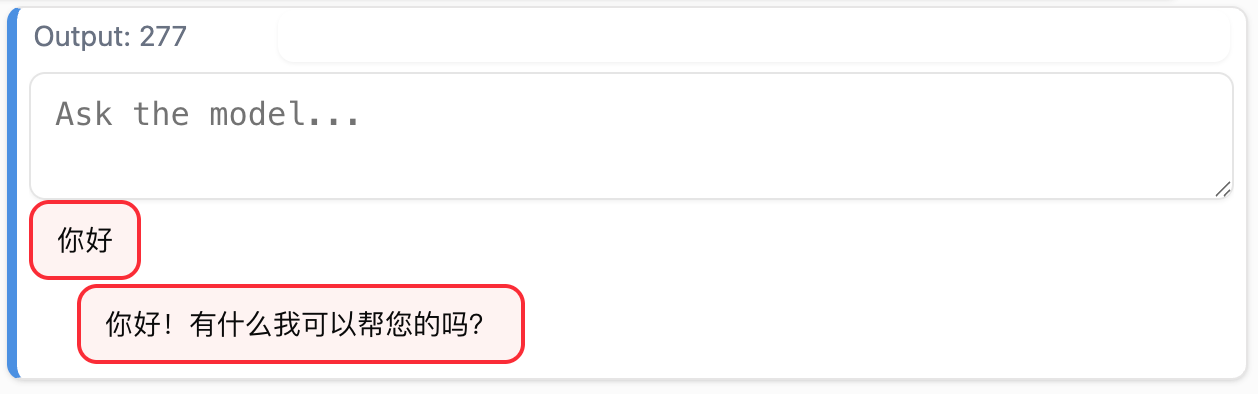

`ask_llm`, alongside quering the model, stores the conversation with a
`type` marker for rendering and syncs the history to the database.

In [ ]:
def test(inp):
    return Div(Div(id='msgs'),
    Form(hx_post=ask_llm, hx_target='#msgs', hx_swap='beforeend', cls='flex items-center space-x-2')(inp, Button('提交', type='submit')))

In [ ]:
prev(test(Inp(id='qry')))

<iframe srcdoc=" <!doctype html>
 <html>
 <head>
 <title>FastHTML page</title>
 <link rel="canonical" href="https://testserver/_sOwJPhU5QG2fgQZgOB898g">
 <meta charset="utf-8">
 <meta name="viewport" content="width=device-width, initial-scale=1, viewport-fit=cover">
<script src="https://cdn.jsdelivr.net/npm/htmx.org@2.0.7/dist/htmx.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/fasthtml-js@1.0.12/fasthtml.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/surreal@main/surreal.js"></script><script src="https://cdn.jsdelivr.net/gh/gnat/css-scope-inline@main/script.js"></script><script src="https://cdn.jsdelivr.net/npm/@tailwindcss/browser@4"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/basecoat.cdn.min.css">
<script src="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/js/all.min.js" defer></script><script type="module">import { marked } from "https://cdn.jsdelivr.net/npm/marked/lib/marked.esm.js";
proc_htmx('.marked', e => e.innerHTML = marked.parse(e.textContent));</script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-dark.css" media="(prefers-color-scheme: dark)">
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-light.css" media="(prefers-color-scheme: light)">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/highlight.min.js"></script><script src="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.js"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.css">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/languages/python.min.js"></script><script type="module">
hljs.addPlugin(new CopyButtonPlugin());
hljs.configure({'cssSelector': 'pre code:not([data-highlighted="yes"])'});
htmx.onLoad(hljs.highlightAll);</script><script>
 function sendmsg() {
 window.parent.postMessage({height: document.documentElement.offsetHeight}, '*');
 }
 window.onload = function() {
 sendmsg();
 document.body.addEventListener('htmx:afterSettle', sendmsg);
 document.body.addEventListener('htmx:wsAfterMessage', sendmsg);
 };</script> </head>
 <body>
 <div>
 <div id="msgs"></div>
<form hx-post="/ask_llm" hx-target="#msgs" hx-swap="beforeend" class="flex items-center space-x-2"><textarea type="text" rows="1" placeholder="输入内容···" id="qry" class="textarea font-mono" name="qry"></textarea><button type="submit" class="btn ">提交</button></form> </div>
 </body>
 </html>
" style="width: 100%; height: auto; border: none;" onload="{
 let frame = this;
 window.addEventListener('message', function(e) {
 if (e.source !== frame.contentWindow) return; // Only proceed if the message is from this iframe
 if (e.data.height) frame.style.height = (e.data.height+1) + 'px';
 }, false);
 }" allow="accelerometer; autoplay; camera; clipboard-read; clipboard-write; display-capture; encrypted-media; fullscreen; gamepad; geolocation; gyroscope; hid; identity-credentials-get; idle-detection; magnetometer; microphone; midi; payment; picture-in-picture; publickey-credentials-get; screen-wake-lock; serial; usb; web-share; xr-spatial-tracking">

In [ ]:
user_chats

{(1, 1): (<lisette.core.Chat at 0x70ee1a6efda0>,
  <IPython.terminal.interactiveshell.TerminalInteractiveShell at 0x70ee225f31a0>)}

### Code Route

In [ ]:
sh = get_shell(); sh

In [ ]:
??get_shell

`get_shell` relies on IPython under the hood.

In [ ]:
def ex(code, sh):
    res = sh.run_cell(code)
    return res.result if res.result else res.stdout

In [ ]:
@rt
def ex_code(code:str, session):
    c,sh = get_chat(session)
    add_hist(c.hist, 'code', f'[INTERPRETER INPUT]\n```py\n{code}\n```')
    res = ex(code, sh)
    add_hist(c.hist, 'code', f'[INTERPRETER OUTPUT]\n```py\n{res}\n```', role='assistant')
    sync_hist(session, c.hist)
    return mk_reply(inp=f'```py\n{code}\n```', out= f'```py\n{res}\n```', color='code', name='code', placeholder=t('your_code'))

`ex_code` similarly also stores the conversation with a `type` marker
and syncs with the database. A special `'[INTERPRETER INPUT/OUTPUT]'`
marker is also added as indicators for the LLM.

In [ ]:
prev(Div(
    Div(id='msgs'),
    Form(hx_post=ex_code, hx_target='#msgs', hx_swap='beforeend', cls='flex items-center space-x-2')(Inp(name='code'), Button('提交', type='submit'))
))

<iframe srcdoc=" <!doctype html>
 <html>
 <head>
 <title>FastHTML page</title>
 <link rel="canonical" href="https://testserver/_gpzn5PagQLu_sL3pcQnBjA">
 <meta charset="utf-8">
 <meta name="viewport" content="width=device-width, initial-scale=1, viewport-fit=cover">
<script src="https://cdn.jsdelivr.net/npm/htmx.org@2.0.7/dist/htmx.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/fasthtml-js@1.0.12/fasthtml.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/surreal@main/surreal.js"></script><script src="https://cdn.jsdelivr.net/gh/gnat/css-scope-inline@main/script.js"></script><script src="https://cdn.jsdelivr.net/npm/@tailwindcss/browser@4"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/basecoat.cdn.min.css">
<script src="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/js/all.min.js" defer></script><script type="module">import { marked } from "https://cdn.jsdelivr.net/npm/marked/lib/marked.esm.js";
proc_htmx('.marked', e => e.innerHTML = marked.parse(e.textContent));</script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-dark.css" media="(prefers-color-scheme: dark)">
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-light.css" media="(prefers-color-scheme: light)">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/highlight.min.js"></script><script src="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.js"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.css">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/languages/python.min.js"></script><script type="module">
hljs.addPlugin(new CopyButtonPlugin());
hljs.configure({'cssSelector': 'pre code:not([data-highlighted="yes"])'});
htmx.onLoad(hljs.highlightAll);</script><script>
 function sendmsg() {
 window.parent.postMessage({height: document.documentElement.offsetHeight}, '*');
 }
 window.onload = function() {
 sendmsg();
 document.body.addEventListener('htmx:afterSettle', sendmsg);
 document.body.addEventListener('htmx:wsAfterMessage', sendmsg);
 };</script> </head>
 <body>
 <div>
 <div id="msgs"></div>
<form hx-post="/ex_code" hx-target="#msgs" hx-swap="beforeend" class="flex items-center space-x-2"><textarea type="text" rows="1" placeholder="输入内容···" name="code" id="inp" class="textarea font-mono"></textarea><button type="submit" class="btn ">提交</button></form> </div>
 </body>
 </html>
" style="width: 100%; height: auto; border: none;" onload="{
 let frame = this;
 window.addEventListener('message', function(e) {
 if (e.source !== frame.contentWindow) return; // Only proceed if the message is from this iframe
 if (e.data.height) frame.style.height = (e.data.height+1) + 'px';
 }, false);
 }" allow="accelerometer; autoplay; camera; clipboard-read; clipboard-write; display-capture; encrypted-media; fullscreen; gamepad; geolocation; gyroscope; hid; identity-credentials-get; idle-detection; magnetometer; microphone; midi; payment; picture-in-picture; publickey-credentials-get; screen-wake-lock; serial; usb; web-share; xr-spatial-tracking">

### Note Route

In [ ]:
@rt
def add_note(note:str, session):
    c,sh = get_chat(session)
    add_hist(c.hist, 'note', content=note,)
    sync_hist(session, c.hist)
    return mk_reply(note, '', 'note', 'note', t('any_thoughts'))

In [ ]:
def test(inp):
    return Div(Div(id='msgs'),
    Form(hx_post=add_note, hx_target='#msgs', hx_swap='beforeend', cls='flex items-center space-x-2')(inp, Button('提交', type='submit')))

In [ ]:
prev(test(Inp(id='note')))

<iframe srcdoc=" <!doctype html>
 <html>
 <head>
 <title>FastHTML page</title>
 <link rel="canonical" href="https://testserver/_VCXLYIKUQ729Sx7Bs_EvCw">
 <meta charset="utf-8">
 <meta name="viewport" content="width=device-width, initial-scale=1, viewport-fit=cover">
<script src="https://cdn.jsdelivr.net/npm/htmx.org@2.0.7/dist/htmx.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/fasthtml-js@1.0.12/fasthtml.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/surreal@main/surreal.js"></script><script src="https://cdn.jsdelivr.net/gh/gnat/css-scope-inline@main/script.js"></script><script src="https://cdn.jsdelivr.net/npm/@tailwindcss/browser@4"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/basecoat.cdn.min.css">
<script src="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/js/all.min.js" defer></script><script type="module">import { marked } from "https://cdn.jsdelivr.net/npm/marked/lib/marked.esm.js";
proc_htmx('.marked', e => e.innerHTML = marked.parse(e.textContent));</script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-dark.css" media="(prefers-color-scheme: dark)">
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-light.css" media="(prefers-color-scheme: light)">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/highlight.min.js"></script><script src="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.js"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.css">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/languages/python.min.js"></script><script type="module">
hljs.addPlugin(new CopyButtonPlugin());
hljs.configure({'cssSelector': 'pre code:not([data-highlighted="yes"])'});
htmx.onLoad(hljs.highlightAll);</script><script>
 function sendmsg() {
 window.parent.postMessage({height: document.documentElement.offsetHeight}, '*');
 }
 window.onload = function() {
 sendmsg();
 document.body.addEventListener('htmx:afterSettle', sendmsg);
 document.body.addEventListener('htmx:wsAfterMessage', sendmsg);
 };</script> </head>
 <body>
 <div>
 <div id="msgs"></div>
<form hx-post="/add_note" hx-target="#msgs" hx-swap="beforeend" class="flex items-center space-x-2"><textarea type="text" rows="1" placeholder="输入内容···" id="note" class="textarea font-mono" name="note"></textarea><button type="submit" class="btn ">提交</button></form> </div>
 </body>
 </html>
" style="width: 100%; height: auto; border: none;" onload="{
 let frame = this;
 window.addEventListener('message', function(e) {
 if (e.source !== frame.contentWindow) return; // Only proceed if the message is from this iframe
 if (e.data.height) frame.style.height = (e.data.height+1) + 'px';
 }, false);
 }" allow="accelerometer; autoplay; camera; clipboard-read; clipboard-write; display-capture; encrypted-media; fullscreen; gamepad; geolocation; gyroscope; hid; identity-credentials-get; idle-detection; magnetometer; microphone; midi; payment; picture-in-picture; publickey-credentials-get; screen-wake-lock; serial; usb; web-share; xr-spatial-tracking">

### Editor Component

Three editor components for the different message types. Each editor is
a form that posts to its corresponding route (ex_code, ask_llm, or
add_note) and appends the result to the message area.

In [ ]:
@rt
def code_editor(session): return Form(hx_post=ex_code, hx_target='#msgs', hx_swap='beforeend', cls='flex items-stretch space-x-2')(Inp(placeholder=t('enter_code', session), name='code', onkeydown="if(event.shiftKey && event.key==='Enter') { event.preventDefault(); this.form.requestSubmit(); }"), Button(t('submit', session), type='submit', cls='self-stretch h-auto'))

The editor routes need the session cookie for translations because each
editor is loaded in a separate request. Since `ContextVar` resets with
each new request, we need to re-set the language from the session at the
start of each request.

In [ ]:
prev(Div(Div(id='msgs'),Div(hx_get=code_editor, hx_trigger='load')))

<iframe srcdoc=" <!doctype html>
 <html>
 <head>
 <title>FastHTML page</title>
 <link rel="canonical" href="https://testserver/_TP4ozbZ9R6im9-QhRIq3kw">
 <meta charset="utf-8">
 <meta name="viewport" content="width=device-width, initial-scale=1, viewport-fit=cover">
<script src="https://cdn.jsdelivr.net/npm/htmx.org@2.0.7/dist/htmx.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/fasthtml-js@1.0.12/fasthtml.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/surreal@main/surreal.js"></script><script src="https://cdn.jsdelivr.net/gh/gnat/css-scope-inline@main/script.js"></script><script src="https://cdn.jsdelivr.net/npm/@tailwindcss/browser@4"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/basecoat.cdn.min.css">
<script src="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/js/all.min.js" defer></script><script type="module">import { marked } from "https://cdn.jsdelivr.net/npm/marked/lib/marked.esm.js";
proc_htmx('.marked', e => e.innerHTML = marked.parse(e.textContent));</script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-dark.css" media="(prefers-color-scheme: dark)">
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-light.css" media="(prefers-color-scheme: light)">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/highlight.min.js"></script><script src="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.js"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.css">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/languages/python.min.js"></script><script type="module">
hljs.addPlugin(new CopyButtonPlugin());
hljs.configure({'cssSelector': 'pre code:not([data-highlighted="yes"])'});
htmx.onLoad(hljs.highlightAll);</script><script>
 function sendmsg() {
 window.parent.postMessage({height: document.documentElement.offsetHeight}, '*');
 }
 window.onload = function() {
 sendmsg();
 document.body.addEventListener('htmx:afterSettle', sendmsg);
 document.body.addEventListener('htmx:wsAfterMessage', sendmsg);
 };</script> </head>
 <body>
 <div>
 <div id="msgs"></div>
 <div hx-get="/code_editor" hx-trigger="load"></div>
 </div>
 </body>
 </html>
" style="width: 100%; height: auto; border: none;" onload="{
 let frame = this;
 window.addEventListener('message', function(e) {
 if (e.source !== frame.contentWindow) return; // Only proceed if the message is from this iframe
 if (e.data.height) frame.style.height = (e.data.height+1) + 'px';
 }, false);
 }" allow="accelerometer; autoplay; camera; clipboard-read; clipboard-write; display-capture; encrypted-media; fullscreen; gamepad; geolocation; gyroscope; hid; identity-credentials-get; idle-detection; magnetometer; microphone; midi; payment; picture-in-picture; publickey-credentials-get; screen-wake-lock; serial; usb; web-share; xr-spatial-tracking">

In [ ]:
@rt
def llm_editor(session): return Form(hx_post=ask_llm, hx_target='#msgs', hx_swap='beforeend', cls='flex items-center space-x-2')(Inp(placeholder=t('ask_model', session), name='qry', onkeydown="if(event.shiftKey && event.key==='Enter') { event.preventDefault(); this.form.requestSubmit(); }"), Button(t('submit', session), type='submit', cls='self-stretch h-auto'))

In [ ]:
prev(llm_editor)

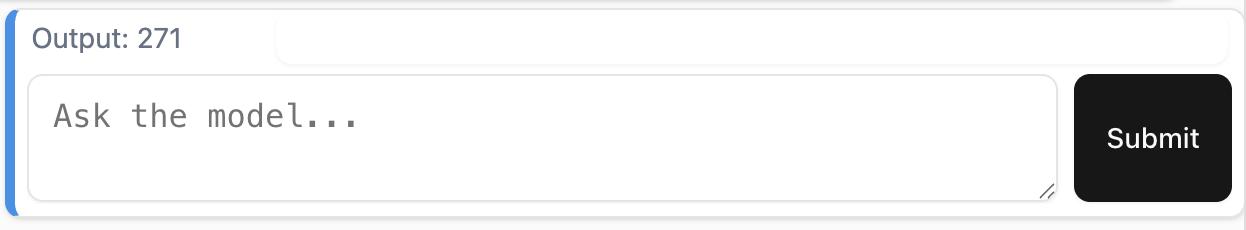

In [ ]:
@rt
def note_editor(session): return Form(hx_post=add_note, hx_target='#msgs', hx_swap='beforeend', cls='flex items-center space-x-2')(Inp(placeholder=t('any_thoughts', session), name='note', onkeydown="if(event.shiftKey && event.key==='Enter') { event.preventDefault(); this.form.requestSubmit(); }"), Button(t('submit', session), type='submit', cls='self-stretch h-auto'))

In [ ]:
prev(note_editor)

In [ ]:
![](../images/31_solveit_in_solveit/4.png)

/bin/bash: -c: line 1: syntax error near unexpected token `../images/31_solveit_in_solveit/4.png'
/bin/bash: -c: line 1: `[](../images/31_solveit_in_solveit/4.png)'

### Tabs

A tabbed navigation bar that lets users switch between the three editor
types—code, prompt, and note. Each tab triggers an HTMX request to load
the corresponding editor form into the editor container.

In [ ]:
def Tab(title, id, hx_post, **kwargs): return fc.Button(title, id=f'{id}-tab', type='button', role='tab', hx_post=hx_post, hx_target='#editor', hx_swap='innerHTML', **kwargs)

In [ ]:
prev(Nav(Tab('标签', id='test', hx_post=None), cls='w-full', role='tablist'))

<iframe srcdoc=" <!doctype html>
 <html>
 <head>
 <title>FastHTML page</title>
 <link rel="canonical" href="https://testserver/_mALelgv5S2OwXq8-G3Ewxw">
 <meta charset="utf-8">
 <meta name="viewport" content="width=device-width, initial-scale=1, viewport-fit=cover">
<script src="https://cdn.jsdelivr.net/npm/htmx.org@2.0.7/dist/htmx.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/fasthtml-js@1.0.12/fasthtml.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/surreal@main/surreal.js"></script><script src="https://cdn.jsdelivr.net/gh/gnat/css-scope-inline@main/script.js"></script><script src="https://cdn.jsdelivr.net/npm/@tailwindcss/browser@4"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/basecoat.cdn.min.css">
<script src="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/js/all.min.js" defer></script><script type="module">import { marked } from "https://cdn.jsdelivr.net/npm/marked/lib/marked.esm.js";
proc_htmx('.marked', e => e.innerHTML = marked.parse(e.textContent));</script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-dark.css" media="(prefers-color-scheme: dark)">
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-light.css" media="(prefers-color-scheme: light)">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/highlight.min.js"></script><script src="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.js"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.css">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/languages/python.min.js"></script><script type="module">
hljs.addPlugin(new CopyButtonPlugin());
hljs.configure({'cssSelector': 'pre code:not([data-highlighted="yes"])'});
htmx.onLoad(hljs.highlightAll);</script><script>
 function sendmsg() {
 window.parent.postMessage({height: document.documentElement.offsetHeight}, '*');
 }
 window.onload = function() {
 sendmsg();
 document.body.addEventListener('htmx:afterSettle', sendmsg);
 document.body.addEventListener('htmx:wsAfterMessage', sendmsg);
 };</script> </head>
 <body>
 <nav class="w-full" role="tablist">
<button type="button" role="tab" hx-swap="innerHTML" hx-target="#editor" id="test-tab" name="test-tab">标签</button> </nav>
 </body>
 </html>
" style="width: 100%; height: auto; border: none;" onload="{
 let frame = this;
 window.addEventListener('message', function(e) {
 if (e.source !== frame.contentWindow) return; // Only proceed if the message is from this iframe
 if (e.data.height) frame.style.height = (e.data.height+1) + 'px';
 }, false);
 }" allow="accelerometer; autoplay; camera; clipboard-read; clipboard-write; display-capture; encrypted-media; fullscreen; gamepad; geolocation; gyroscope; hid; identity-credentials-get; idle-detection; magnetometer; microphone; midi; payment; picture-in-picture; publickey-credentials-get; screen-wake-lock; serial; usb; web-share; xr-spatial-tracking">

In [ ]:
def TabBar(cls='', *args, **kwargs): 
    return Nav(
        Tab(t('code'), id='code', hx_post=code_editor),
        Tab(t('prompt'), id='qry', hx_post=llm_editor),
        Tab(t('note'), id='note', hx_post=note_editor),
        cls=f'w-full {cls}', role='tablist', *args, **kwargs
    )

In [ ]:
prev(Div(TabBar(), Div(id='editor'), cls='tabs w-full'))

<iframe srcdoc=" <!doctype html>
 <html>
 <head>
 <title>FastHTML page</title>
 <link rel="canonical" href="https://testserver/_1osIrIiPS2_bxJ-sxvruzQ">
 <meta charset="utf-8">
 <meta name="viewport" content="width=device-width, initial-scale=1, viewport-fit=cover">
<script src="https://cdn.jsdelivr.net/npm/htmx.org@2.0.7/dist/htmx.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/fasthtml-js@1.0.12/fasthtml.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/surreal@main/surreal.js"></script><script src="https://cdn.jsdelivr.net/gh/gnat/css-scope-inline@main/script.js"></script><script src="https://cdn.jsdelivr.net/npm/@tailwindcss/browser@4"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/basecoat.cdn.min.css">
<script src="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/js/all.min.js" defer></script><script type="module">import { marked } from "https://cdn.jsdelivr.net/npm/marked/lib/marked.esm.js";
proc_htmx('.marked', e => e.innerHTML = marked.parse(e.textContent));</script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-dark.css" media="(prefers-color-scheme: dark)">
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-light.css" media="(prefers-color-scheme: light)">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/highlight.min.js"></script><script src="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.js"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.css">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/languages/python.min.js"></script><script type="module">
hljs.addPlugin(new CopyButtonPlugin());
hljs.configure({'cssSelector': 'pre code:not([data-highlighted="yes"])'});
htmx.onLoad(hljs.highlightAll);</script><script>
 function sendmsg() {
 window.parent.postMessage({height: document.documentElement.offsetHeight}, '*');
 }
 window.onload = function() {
 sendmsg();
 document.body.addEventListener('htmx:afterSettle', sendmsg);
 document.body.addEventListener('htmx:wsAfterMessage', sendmsg);
 };</script> </head>
 <body>
 <div class="tabs w-full">
 <nav class="w-full " role="tablist">
<button type="button" role="tab" hx-post="/code_editor" hx-swap="innerHTML" hx-target="#editor" id="code-tab" name="code-tab">Code</button><button type="button" role="tab" hx-post="/llm_editor" hx-swap="innerHTML" hx-target="#editor" id="qry-tab" name="qry-tab">Prompt</button><button type="button" role="tab" hx-post="/note_editor" hx-swap="innerHTML" hx-target="#editor" id="note-tab" name="note-tab">Note</button> </nav>
 <div id="editor"></div>
 </div>
 </body>
 </html>
" style="width: 100%; height: auto; border: none;" onload="{
 let frame = this;
 window.addEventListener('message', function(e) {
 if (e.source !== frame.contentWindow) return; // Only proceed if the message is from this iframe
 if (e.data.height) frame.style.height = (e.data.height+1) + 'px';
 }, false);
 }" allow="accelerometer; autoplay; camera; clipboard-read; clipboard-write; display-capture; encrypted-media; fullscreen; gamepad; geolocation; gyroscope; hid; identity-credentials-get; idle-detection; magnetometer; microphone; midi; payment; picture-in-picture; publickey-credentials-get; screen-wake-lock; serial; usb; web-share; xr-spatial-tracking">

### Render Existing Messages

In [ ]:
@rt
def load_messages(session):
    c,sh = get_chat(session)
    for i in c.hist:
        role = i.get('role') if isinstance(i, dict) else i.role
        if role=='user':      yield Div(Bubble(i['content'].replace('[INTERPRETER INPUT]\n', ''), i['type']), cls='space-y-0.5')
        if role=='assistant': yield Div(Bubble(i['content'].replace('[INTERPRETER OUTPUT]\n', ''), i['type'], 'r'), cls='space-y-0.5')

In [ ]:
prev(f'/load_messages')

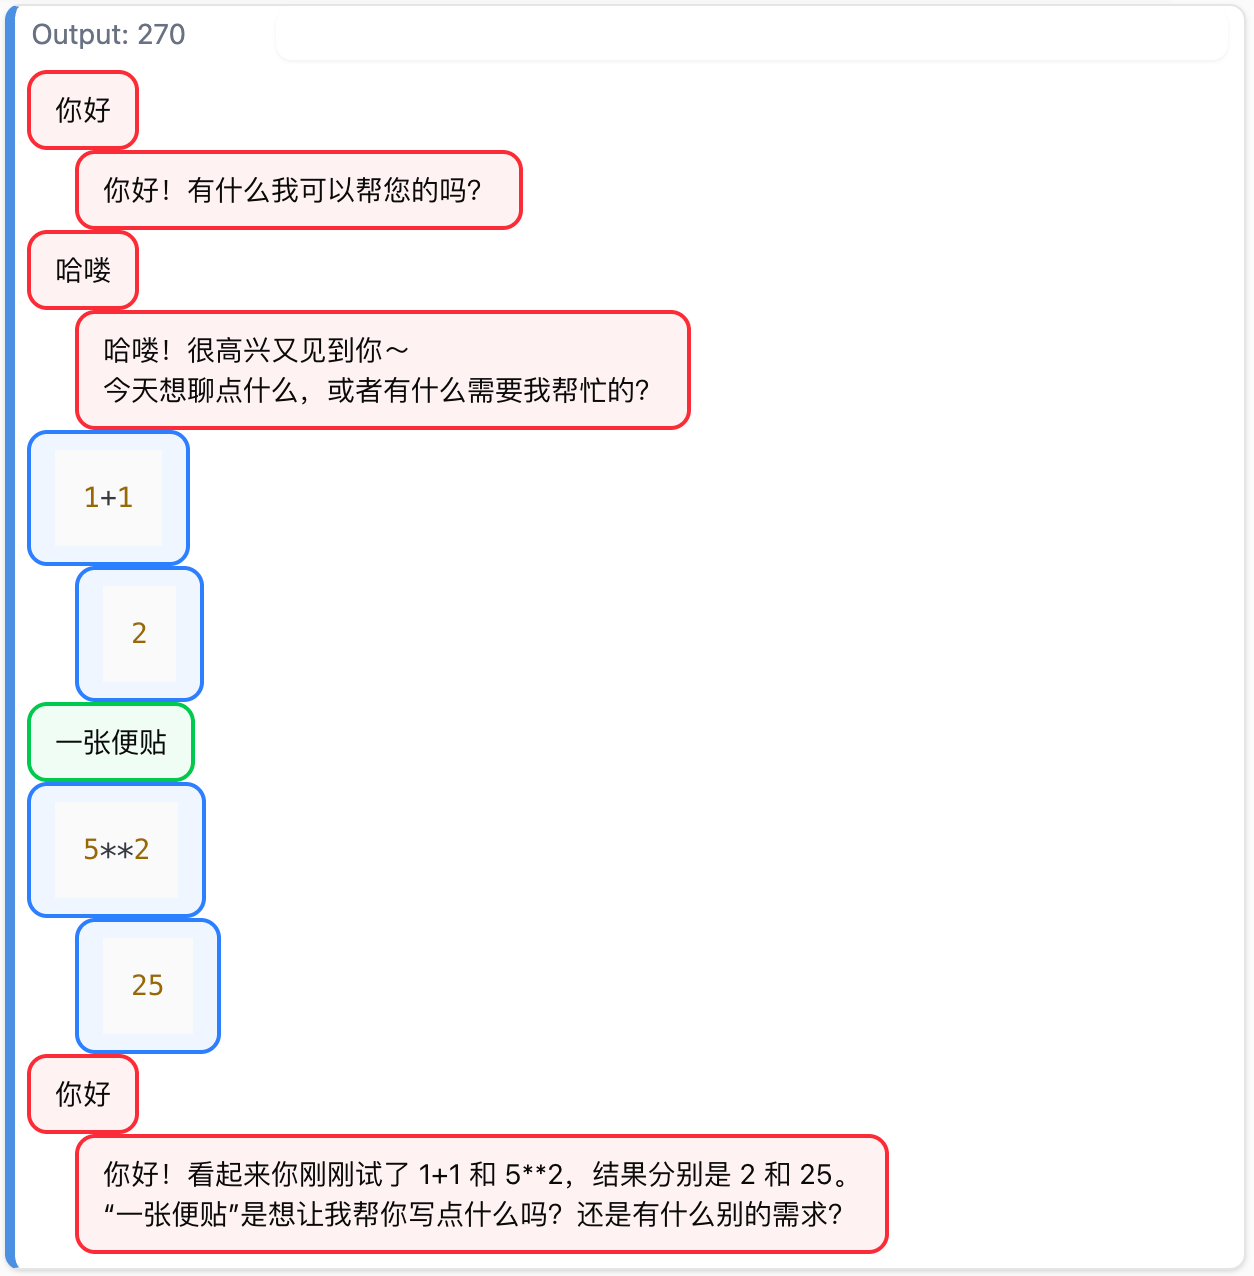

### Dialog

The dialog component ties everything together—a title bar that supports
inline editing, a message display area that loads existing conversation
history, and the tabbed editor for adding new messages. Clicking a
dialog name makes it editable, and saving updates the database
immediately.

In [ ]:
@rt
def edit_dname(session):
    dname = dialogs[(session['userid'], session['current_dialog'])].name
    return Form(id='dname', hx_post=save_dname, hx_target='#dname', hx_swap='outerHTML')(
        Input(value=dname, name='newname', autofocus=True, onfocus='this.select()', required=True, cls='text-2xl font-bold outline-none'),
        Button(t('save', session), type='submit')
    )

In [ ]:
@rt 
def save_dname(session, newname:str):
    dialogs.update(uid=session['userid'], dialog_num=session['current_dialog'], name=newname)
    return DialogTitle(newname)

In [ ]:
def DialogTitle(name): return H1(name, cls='text-2xl font-bold', id='dname', hx_get=edit_dname, hx_target='#dname', hx_swap='outerHTML')

In [ ]:
prev(DialogTitle('对话'))

<iframe srcdoc=" <!doctype html>
 <html>
 <head>
 <title>FastHTML page</title>
 <link rel="canonical" href="https://testserver/_k7gfueTcTcqBaOF87mC30w">
 <meta charset="utf-8">
 <meta name="viewport" content="width=device-width, initial-scale=1, viewport-fit=cover">
<script src="https://cdn.jsdelivr.net/npm/htmx.org@2.0.7/dist/htmx.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/fasthtml-js@1.0.12/fasthtml.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/surreal@main/surreal.js"></script><script src="https://cdn.jsdelivr.net/gh/gnat/css-scope-inline@main/script.js"></script><script src="https://cdn.jsdelivr.net/npm/@tailwindcss/browser@4"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/basecoat.cdn.min.css">
<script src="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/js/all.min.js" defer></script><script type="module">import { marked } from "https://cdn.jsdelivr.net/npm/marked/lib/marked.esm.js";
proc_htmx('.marked', e => e.innerHTML = marked.parse(e.textContent));</script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-dark.css" media="(prefers-color-scheme: dark)">
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-light.css" media="(prefers-color-scheme: light)">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/highlight.min.js"></script><script src="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.js"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.css">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/languages/python.min.js"></script><script type="module">
hljs.addPlugin(new CopyButtonPlugin());
hljs.configure({'cssSelector': 'pre code:not([data-highlighted="yes"])'});
htmx.onLoad(hljs.highlightAll);</script><script>
 function sendmsg() {
 window.parent.postMessage({height: document.documentElement.offsetHeight}, '*');
 }
 window.onload = function() {
 sendmsg();
 document.body.addEventListener('htmx:afterSettle', sendmsg);
 document.body.addEventListener('htmx:wsAfterMessage', sendmsg);
 };</script> </head>
 <body>
 <h1 class="text-2xl font-bold" id="dname" hx-get="/edit_dname" hx-target="#dname" hx-swap="outerHTML">对话</h1>
 </body>
 </html>
" style="width: 100%; height: auto; border: none;" onload="{
 let frame = this;
 window.addEventListener('message', function(e) {
 if (e.source !== frame.contentWindow) return; // Only proceed if the message is from this iframe
 if (e.data.height) frame.style.height = (e.data.height+1) + 'px';
 }, false);
 }" allow="accelerometer; autoplay; camera; clipboard-read; clipboard-write; display-capture; encrypted-media; fullscreen; gamepad; geolocation; gyroscope; hid; identity-credentials-get; idle-detection; magnetometer; microphone; midi; payment; picture-in-picture; publickey-credentials-get; screen-wake-lock; serial; usb; web-share; xr-spatial-tracking">

In [ ]:
@rt
def dialog(dnum:int, session): 
    session['current_dialog'] = dnum
    return Div(
        DialogTitle(dialogs[(session['userid'], dnum)].name),
        Div(id='msgs', cls='p-8 max-h-96 overflow-y-auto', hx_get=load_messages, hx_trigger='load'),
        TabBar(id='tabbar'),
        Div(id='editor'),
        cls='tabs w-full'
    )

In [ ]:
prev('dialog?dnum=1')

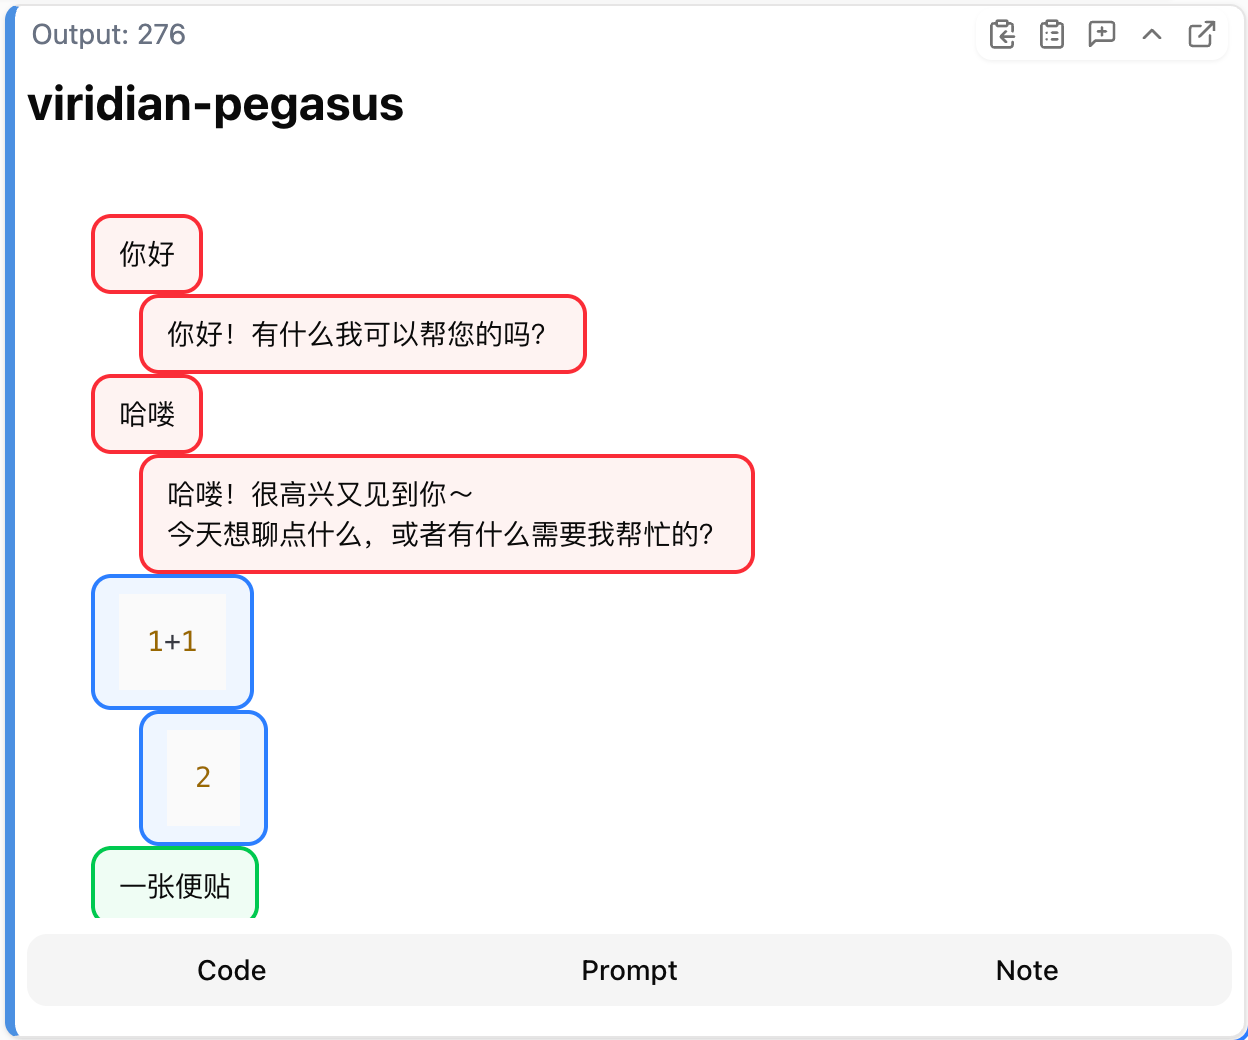

### Delete Dialog

In [ ]:
@rt
def delete_dialog(session, dnum:int):
    uid = session.get('userid')
    dialogs.delete((uid, dnum))
    del user_chats[(uid, dnum)]

In [ ]:
fake_session

{'userid': 1, 'current_dialog': 1}

In [ ]:
users(), dialogs()

([User(id=1, restore_code='provocative-lori-of-acceptance')],
 [Dialog(id=None, uid=1, dialog_num=1, name='viridian-pegasus', messages='[{"role": "user", "content": "\\u4f60\\u597d", "type": "prompt"}, {"content": "\\u4f60\\u597d\\uff01\\u6709\\u4ec0\\u4e48\\u6211\\u53ef\\u4ee5\\u5e2e\\u60a8\\u7684\\u5417\\uff1f", "role": "assistant", "tool_calls": null, "function_call": null, "provider_specific_fields": {"refusal": null}, "type": "prompt"}, {"role": "user", "content": "\\u54c8\\u55bd", "type": "prompt"}, {"content": "\\u54c8\\u55bd\\uff01\\u5f88\\u9ad8\\u5174\\u53c8\\u89c1\\u5230\\u4f60\\uff5e  \\n\\u4eca\\u5929\\u60f3\\u804a\\u70b9\\u4ec0\\u4e48\\uff0c\\u6216\\u8005\\u6709\\u4ec0\\u4e48\\u9700\\u8981\\u6211\\u5e2e\\u5fd9\\u7684\\uff1f", "role": "assistant", "tool_calls": null, "function_call": null, "provider_specific_fields": {"refusal": null}, "type": "prompt"}, {"role": "user", "content": "[INTERPRETER INPUT]\\n```py\\n1+1\\n```", "type": "code"}, {"role": "assistant", "content": 

In [ ]:
user_chats

{(1, 1): (<lisette.core.Chat at 0x70ee1a6efda0>,
  <IPython.terminal.interactiveshell.TerminalInteractiveShell at 0x70ee225f31a0>)}

In [ ]:
delete_dialog(fake_session, 1)

In [ ]:
users(), dialogs()

([User(id=1, restore_code='provocative-lori-of-acceptance')], [])

In [ ]:
user_chats

{}

### Restore Dialog

The restore session feature allows users to recover their data if the
server restarts or they switch devices. Users enter their unique restore
code (generated at account creation), which looks up their account in
the database. If found, it restores their session by setting the user
ID, loading their first dialog, and redirecting to the main page. A
destructive alert displays if the restore code is invalid.

In [ ]:
insolveit = 'IN_SOLVEIT' in os.environ

In [ ]:
insolveit

True

I’ve created the `insolveit` check to determine whether the app is
running in my SolveIt instance or whether as a deployed app.

In [ ]:
@rt
def restore_session(restore_code:str, session):
    if (u:=first(users('restore_code=?', [restore_code]))):
        session['userid'] = u.id
        existing = dialogs(where=f'uid={u.id}')
        if existing: session['current_dialog'] = existing[0].dialog_num
        setsession(session)
        return HtmxResponseHeaders(redirect='/main' if insolveit else '/')
    else: return Div(cls='alert-destructive')(H2(t('restore_failed')), Section(t('restore_error')))

    session['userid'] = first(users('restore_code=?', [restore_code])).id
    setsession(session)

In [ ]:
prev('/restore_session?restore_code=haha')

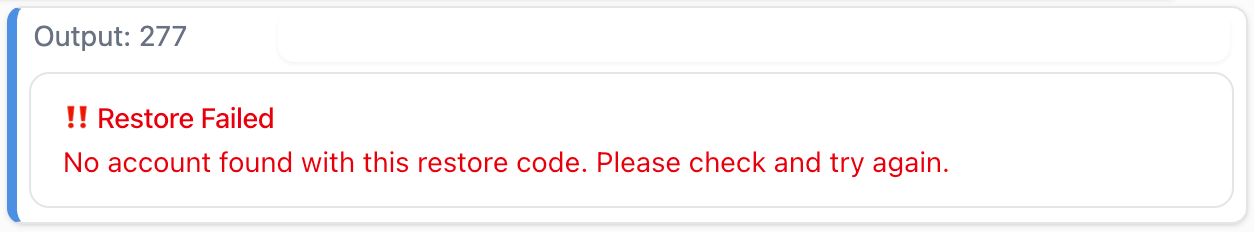

In [ ]:
user_chats

{}

In [ ]:
users[1].restore_code

'provocative-lori-of-acceptance'

In [ ]:
user_chats = {}
prev(restore_session.to(restore_code=users[1].restore_code))

<iframe src="/restore_session?restore_code=provocative-lori-of-acceptance" style="width: 100%; height: auto; border: none;" onload="{
 let frame = this;
 window.addEventListener('message', function(e) {
 if (e.source !== frame.contentWindow) return; // Only proceed if the message is from this iframe
 if (e.data.height) frame.style.height = (e.data.height+1) + 'px';
 }, false);
 }" allow="accelerometer; autoplay; camera; clipboard-read; clipboard-write; display-capture; encrypted-media; fullscreen; gamepad; geolocation; gyroscope; hid; identity-credentials-get; idle-detection; magnetometer; microphone; midi; payment; picture-in-picture; publickey-credentials-get; screen-wake-lock; serial; usb; web-share; xr-spatial-tracking">

In [ ]:
user_chats

{(1, 1): (<lisette.core.Chat at 0x70ee0bf336e0>,
  <IPython.terminal.interactiveshell.TerminalInteractiveShell at 0x70ee19188fb0>)}

In [ ]:
prev(Div(
    Form(hx_post=restore_session, hx_target='#alert-area', cls='flex items-end gap-2')(
        Div()(
            Label('恢复码', fr='restore_code', cls='mb-2'),
            Input(placeholder='looks-like-this', type='text', name='restore_code')
        ),
        Button('提交', type='submit')
    ),
    Div(id='alert-area')
))

<iframe srcdoc=" <!doctype html>
 <html>
 <head>
 <title>FastHTML page</title>
 <link rel="canonical" href="https://testserver/_q7QSnSCySD_yuaCN8jW8Rg">
 <meta charset="utf-8">
 <meta name="viewport" content="width=device-width, initial-scale=1, viewport-fit=cover">
<script src="https://cdn.jsdelivr.net/npm/htmx.org@2.0.7/dist/htmx.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/fasthtml-js@1.0.12/fasthtml.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/surreal@main/surreal.js"></script><script src="https://cdn.jsdelivr.net/gh/gnat/css-scope-inline@main/script.js"></script><script src="https://cdn.jsdelivr.net/npm/@tailwindcss/browser@4"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/basecoat.cdn.min.css">
<script src="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/js/all.min.js" defer></script><script type="module">import { marked } from "https://cdn.jsdelivr.net/npm/marked/lib/marked.esm.js";
proc_htmx('.marked', e => e.innerHTML = marked.parse(e.textContent));</script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-dark.css" media="(prefers-color-scheme: dark)">
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-light.css" media="(prefers-color-scheme: light)">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/highlight.min.js"></script><script src="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.js"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.css">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/languages/python.min.js"></script><script type="module">
hljs.addPlugin(new CopyButtonPlugin());
hljs.configure({'cssSelector': 'pre code:not([data-highlighted="yes"])'});
htmx.onLoad(hljs.highlightAll);</script><script>
 function sendmsg() {
 window.parent.postMessage({height: document.documentElement.offsetHeight}, '*');
 }
 window.onload = function() {
 sendmsg();
 document.body.addEventListener('htmx:afterSettle', sendmsg);
 document.body.addEventListener('htmx:wsAfterMessage', sendmsg);
 };</script> </head>
 <body>
 <div>
<form hx-post="/restore_session" hx-target="#alert-area" class="flex items-end gap-2"> <div>
<label for="restore_code" class="label mb-2">恢复码</label> <input placeholder="looks-like-this" type="text" name="restore_code" class="input ">
 </div>
<button type="submit" class="btn ">提交</button></form> <div id="alert-area"></div>
 </div>
 </body>
 </html>
" style="width: 100%; height: auto; border: none;" onload="{
 let frame = this;
 window.addEventListener('message', function(e) {
 if (e.source !== frame.contentWindow) return; // Only proceed if the message is from this iframe
 if (e.data.height) frame.style.height = (e.data.height+1) + 'px';
 }, false);
 }" allow="accelerometer; autoplay; camera; clipboard-read; clipboard-write; display-capture; encrypted-media; fullscreen; gamepad; geolocation; gyroscope; hid; identity-credentials-get; idle-detection; magnetometer; microphone; midi; payment; picture-in-picture; publickey-credentials-get; screen-wake-lock; serial; usb; web-share; xr-spatial-tracking">

In [ ]:
def RestoreForm(session, id='restore-form', *args, **kwargs):
    return Form(hx_post=restore_session, hx_target='#alert-box', cls='flex items-end gap-2', id=id, *args, **kwargs)(
        Div(
            Label(t('restore_code'), ' · ', users[session['userid']].restore_code, fr='restore_code', cls='mb-2'),
            Input(type='text', name='restore_code', placeholder=t('enter_restore_code'))
        ),
        Button(t('submit'), type='submit')
    )

In [ ]:
prev(RestoreForm(fake_session))

<iframe srcdoc=" <!doctype html>
 <html>
 <head>
 <title>FastHTML page</title>
 <link rel="canonical" href="https://testserver/_z-mQL0X7R1qfFXWTNVyukA">
 <meta charset="utf-8">
 <meta name="viewport" content="width=device-width, initial-scale=1, viewport-fit=cover">
<script src="https://cdn.jsdelivr.net/npm/htmx.org@2.0.7/dist/htmx.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/fasthtml-js@1.0.12/fasthtml.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/surreal@main/surreal.js"></script><script src="https://cdn.jsdelivr.net/gh/gnat/css-scope-inline@main/script.js"></script><script src="https://cdn.jsdelivr.net/npm/@tailwindcss/browser@4"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/basecoat.cdn.min.css">
<script src="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/js/all.min.js" defer></script><script type="module">import { marked } from "https://cdn.jsdelivr.net/npm/marked/lib/marked.esm.js";
proc_htmx('.marked', e => e.innerHTML = marked.parse(e.textContent));</script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-dark.css" media="(prefers-color-scheme: dark)">
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-light.css" media="(prefers-color-scheme: light)">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/highlight.min.js"></script><script src="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.js"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.css">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/languages/python.min.js"></script><script type="module">
hljs.addPlugin(new CopyButtonPlugin());
hljs.configure({'cssSelector': 'pre code:not([data-highlighted="yes"])'});
htmx.onLoad(hljs.highlightAll);</script><script>
 function sendmsg() {
 window.parent.postMessage({height: document.documentElement.offsetHeight}, '*');
 }
 window.onload = function() {
 sendmsg();
 document.body.addEventListener('htmx:afterSettle', sendmsg);
 document.body.addEventListener('htmx:wsAfterMessage', sendmsg);
 };</script> </head>
 <body>
<form hx-post="/restore_session" hx-target="#alert-box" class="flex items-end gap-2" id="restore-form"> <div>
<label for="restore_code" class="label mb-2">Restore Code · provocative-lori-of-acceptance</label> <input type="text" name="restore_code" placeholder="Enter restore code..." class="input ">
 </div>
<button type="submit" class="btn ">Submit</button></form> </body>
 </html>
" style="width: 100%; height: auto; border: none;" onload="{
 let frame = this;
 window.addEventListener('message', function(e) {
 if (e.source !== frame.contentWindow) return; // Only proceed if the message is from this iframe
 if (e.data.height) frame.style.height = (e.data.height+1) + 'px';
 }, false);
 }" allow="accelerometer; autoplay; camera; clipboard-read; clipboard-write; display-capture; encrypted-media; fullscreen; gamepad; geolocation; gyroscope; hid; identity-credentials-get; idle-detection; magnetometer; microphone; midi; payment; picture-in-picture; publickey-credentials-get; screen-wake-lock; serial; usb; web-share; xr-spatial-tracking">

### Dialog List

The dialog list component displays all dialogs belonging to the current
user. The `display_dialogs` route fetches all user dialogs from the
database and includes a “new dialog” card that triggers dialog creation.
The restore code form is also embedded here, allowing users to recover
their session from a different device.

In [ ]:
@rt
def current_dialog(session): return dialog(session.get('current_dialog'), session)

In [ ]:
def DialogCard(d): return Div(id=f'dialog-{d.uid}{d.dialog_num}', cls='card p-4 hover:bg-gray-100 flex flex-row justify-between items-center')(
    Span(hx_get=dialog.to(dnum=d.dialog_num), hx_target='#content', cls='cursor-pointer')('💬 ', d.name), 
    Button(t('delete'), var='destructive', hx_post=delete_dialog.to(dnum=d.dialog_num), hx_swap='delete', hx_target=f'#dialog-{d.uid}{d.dialog_num}')
)

In [ ]:
prev(DialogCard(first(dialogs())))

<iframe srcdoc=" <!doctype html>
 <html>
 <head>
 <title>FastHTML page</title>
 <link rel="canonical" href="https://testserver/_6Y1bRgKQTmC8z9EN5_DnGA">
 <meta charset="utf-8">
 <meta name="viewport" content="width=device-width, initial-scale=1, viewport-fit=cover">
<script src="https://cdn.jsdelivr.net/npm/htmx.org@2.0.7/dist/htmx.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/fasthtml-js@1.0.12/fasthtml.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/surreal@main/surreal.js"></script><script src="https://cdn.jsdelivr.net/gh/gnat/css-scope-inline@main/script.js"></script><script src="https://cdn.jsdelivr.net/npm/@tailwindcss/browser@4"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/basecoat.cdn.min.css">
<script src="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/js/all.min.js" defer></script><script type="module">import { marked } from "https://cdn.jsdelivr.net/npm/marked/lib/marked.esm.js";
proc_htmx('.marked', e => e.innerHTML = marked.parse(e.textContent));</script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-dark.css" media="(prefers-color-scheme: dark)">
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-light.css" media="(prefers-color-scheme: light)">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/highlight.min.js"></script><script src="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.js"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.css">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/languages/python.min.js"></script><script type="module">
hljs.addPlugin(new CopyButtonPlugin());
hljs.configure({'cssSelector': 'pre code:not([data-highlighted="yes"])'});
htmx.onLoad(hljs.highlightAll);</script><script>
 function sendmsg() {
 window.parent.postMessage({height: document.documentElement.offsetHeight}, '*');
 }
 window.onload = function() {
 sendmsg();
 document.body.addEventListener('htmx:afterSettle', sendmsg);
 document.body.addEventListener('htmx:wsAfterMessage', sendmsg);
 };</script> </head>
 <body>
 <div id="dialog-11" class="card p-4 hover:bg-gray-100 flex flex-row justify-between items-center">
<span hx-get="/dialog?dnum=1" hx-target="#content" class="cursor-pointer">💬 gleaming-tortoise</span><button hx-post="/delete_dialog?dnum=1" hx-swap="delete" hx-target="#dialog-11" class="btn-destructive ">Delete</button> </div>
 </body>
 </html>
" style="width: 100%; height: auto; border: none;" onload="{
 let frame = this;
 window.addEventListener('message', function(e) {
 if (e.source !== frame.contentWindow) return; // Only proceed if the message is from this iframe
 if (e.data.height) frame.style.height = (e.data.height+1) + 'px';
 }, false);
 }" allow="accelerometer; autoplay; camera; clipboard-read; clipboard-write; display-capture; encrypted-media; fullscreen; gamepad; geolocation; gyroscope; hid; identity-credentials-get; idle-detection; magnetometer; microphone; midi; payment; picture-in-picture; publickey-credentials-get; screen-wake-lock; serial; usb; web-share; xr-spatial-tracking">

In [ ]:
@rt
def display_dialogs(session):
    ds = L(dialogs('uid=?', [session.get('userid')]))
    ds = ds.map(lambda d: DialogCard(d))
    return Div(cls='flex flex-col gap-2 max-w-xl')(
        Div(cls='flex items-center justify-between gap-4')(H1(t('all_dialogs', session), cls='text-2xl font-bold', id='all-dialogs-title'), RestoreForm(session)), 
        Div(id='alert-box'),
        Div('➕', Span(t('new_dialog', session), id='new-dialog-text'), cls='card p-4 hover:bg-gray-100 cursor-pointer border-2 border-dashed flex flex-row items-center gap-2', hx_post=create_dialog, hx_target='#content'),
        Div(*ds, cls='flex flex-col gap-2 max-h-64 overflow-y-auto')
    )

In [ ]:
prev(Div(
    Div(id='content')(
        display_dialogs({'userid': 1, 'current_dialog': 11})
    )
))

<iframe srcdoc=" <!doctype html>
 <html>
 <head>
 <title>FastHTML page</title>
 <link rel="canonical" href="https://testserver/_WYKxlDFyRQWPOl1fhn8wFA">
 <meta charset="utf-8">
 <meta name="viewport" content="width=device-width, initial-scale=1, viewport-fit=cover">
<script src="https://cdn.jsdelivr.net/npm/htmx.org@2.0.7/dist/htmx.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/fasthtml-js@1.0.12/fasthtml.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/surreal@main/surreal.js"></script><script src="https://cdn.jsdelivr.net/gh/gnat/css-scope-inline@main/script.js"></script><script src="https://cdn.jsdelivr.net/npm/@tailwindcss/browser@4"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/basecoat.cdn.min.css">
<script src="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/js/all.min.js" defer></script><script type="module">import { marked } from "https://cdn.jsdelivr.net/npm/marked/lib/marked.esm.js";
proc_htmx('.marked', e => e.innerHTML = marked.parse(e.textContent));</script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-dark.css" media="(prefers-color-scheme: dark)">
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/styles/atom-one-light.css" media="(prefers-color-scheme: light)">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/highlight.min.js"></script><script src="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.js"></script> <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/arronhunt/highlightjs-copy/dist/highlightjs-copy.min.css">
<script src="https://cdn.jsdelivr.net/gh/highlightjs/cdn-release/build/languages/python.min.js"></script><script type="module">
hljs.addPlugin(new CopyButtonPlugin());
hljs.configure({'cssSelector': 'pre code:not([data-highlighted="yes"])'});
htmx.onLoad(hljs.highlightAll);</script><script>
 function sendmsg() {
 window.parent.postMessage({height: document.documentElement.offsetHeight}, '*');
 }
 window.onload = function() {
 sendmsg();
 document.body.addEventListener('htmx:afterSettle', sendmsg);
 document.body.addEventListener('htmx:wsAfterMessage', sendmsg);
 };</script> </head>
 <body>
 <div>
 <div id="content">
 <div class="flex flex-col gap-2 max-w-xl">
 <div class="flex items-center justify-between gap-4">
 <h1 class="text-2xl font-bold" id="all-dialogs-title">所有对话</h1>
<form hx-post="/restore_session" hx-target="#alert-box" class="flex items-end gap-2" id="restore-form"> <div>
<label for="restore_code" class="label mb-2">Restore Code · provocative-lori-of-acceptance</label> <input type="text" name="restore_code" placeholder="Enter restore code..." class="input ">
 </div>
<button type="submit" class="btn ">Submit</button></form> </div>
 <div id="alert-box"></div>
 <div class="card p-4 hover:bg-gray-100 cursor-pointer border-2 border-dashed flex flex-row items-center gap-2" hx-post="/create_dialog" hx-target="#content">
➕<span id="new-dialog-text">新对话</span> </div>
 <div class="flex flex-col gap-2 max-h-64 overflow-y-auto">
 <div id="dialog-11" class="card p-4 hover:bg-gray-100 flex flex-row justify-between items-center">
<span hx-get="/dialog?dnum=1" hx-target="#content" class="cursor-pointer">💬 gleaming-tortoise</span><button hx-post="/delete_dialog?dnum=1" hx-swap="delete" hx-target="#dialog-11" class="btn-destructive ">Delete</button> </div>
 </div>
 </div>
 </div>
 </div>
 </body>
 </html>
" style="width: 100%; height: auto; border: none;" onload="{
 let frame = this;
 window.addEventListener('message', function(e) {
 if (e.source !== frame.contentWindow) return; // Only proceed if the message is from this iframe
 if (e.data.height) frame.style.height = (e.data.height+1) + 'px';
 }, false);
 }" allow="accelerometer; autoplay; camera; clipboard-read; clipboard-write; display-capture; encrypted-media; fullscreen; gamepad; geolocation; gyroscope; hid;

### Main Page

In [ ]:
@rt
def toggle_lang(session):
    lang = 'zh' if session.get('lang') == 'en' else 'en'
    current_lang.set(lang)
    session['lang'] = lang
    return (
        H2(t('solveit_lite'), id='title', hx_swap_oob='true'),
        Button(t('all_dialogs'), id='dialogs-btn', hx_post=display_dialogs, hx_target='#content', var='secondary', hx_swap_oob='true'),
        Span(t('code'), hx_swap_oob='innerHTML:#code-tab'),
        Span(t('prompt'), hx_swap_oob='innerHTML:#qry-tab'),
        Span(t('note'), hx_swap_oob='innerHTML:#note-tab'),
        Div(id='editor', hx_swap_oob='true'),
        Footer(t('footer'), id='footer', cls='text-sm text-gray-400', hx_swap_oob='true'),
        RestoreForm(session, hx_swap_oob='true', id='restore-form'),
        H1(t('all_dialogs'), cls='text-2xl font-bold', id='all-dialogs-title', hx_swap_oob='true'),
        Span(t('new_dialog'), id='new-dialog-text', hx_swap_oob='true')
    )

This route allows users to switch between Chinese and English with OOB
swaps to update all translatable text across the page simultaneously.

In [ ]:
@rt('/main' if insolveit else '/')
def main(session):
    setsession(session)
    return Div(id='body', cls='card p-8 max-w-4xl mx-auto my-4')(
        Header(cls='flex justify-between items-center')(H2(
            t('solveit_lite'), id='title'), 
            Span(
                Button('🌐', var='secondary', hx_post=toggle_lang, hx_swap='none'), 
                Button(t('all_dialogs'), id='dialogs-btn', hx_post=display_dialogs, hx_target='#content', var='secondary')
            )
        ),
        Section(id='content')(
            current_dialog(session)
        ),
        Footer(t('footer'), id='footer', cls='text-sm text-gray-400')
    )

In [ ]:
prev('/main')

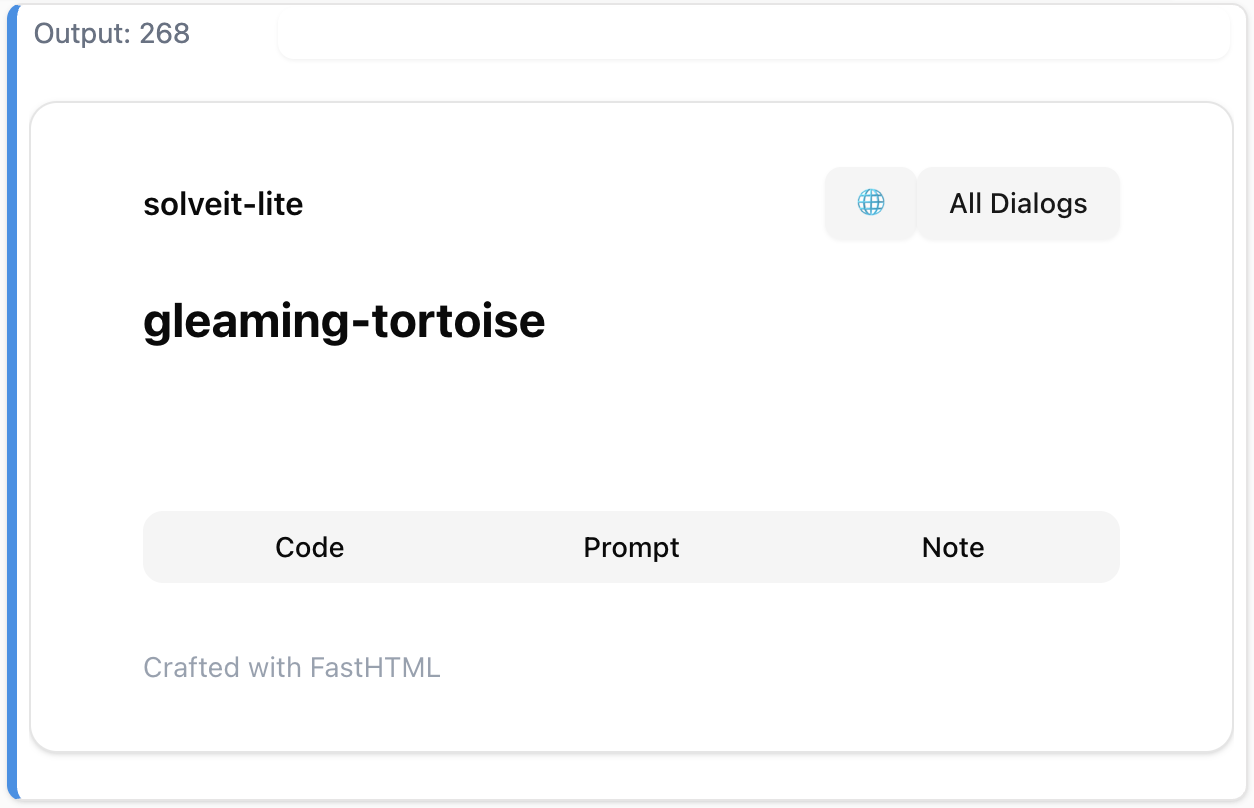

### Deploy

In [ ]:
if not insolveit: serve()

In [ ]:
Path('requirements.txt').write_text('''\
python-fasthtml
lisette
coolname
ipython
''')
!cat requirements.txt

python-fasthtml
lisette
coolname
ipython

In [ ]:
Path('.plash').write_text('export PLASH_APP_NAME=solveit-lite-unofficial')
!cat .plash

export PLASH_APP_NAME=solveit-lite-unofficial

In [ ]:
Path('plash.env').write_text(f'export MOONSHOT_API_KEY={os.environ.get('MOONSHOT_API_KEY')}')

75

In [ ]:
import plash_cli as pc
pc.deploy()

'https://solveit-lite-unofficial.pla.sh'

In [ ]:
print(pc.logs())

Build Start Time: 2026-01-16 01:30:30.917195+00:00
Step 1/14 : FROM plash:latest
 ---> 8c65e51fa2d2
Step 2/14 : ARG USER_UID=1000
 ---> Using cache
 ---> 781580c8e262
Step 3/14 : ARG USER_GID=1000
 ---> Using cache
 ---> dcf3956b8c50
Step 4/14 : RUN groupadd -g $USER_GID plash && useradd -u $USER_UID -g $USER_GID -m plash
 ---> Using cache
 ---> fe019dc49177
Step 5/14 : ENV PLASH_PRODUCTION=1
 ---> Using cache
 ---> a86e28497fc0
Step 6/14 : COPY .dockerignore setup.sh* ./
 ---> Using cache
 ---> 786f3c3d2c09
Step 7/14 : RUN if [ -f ./setup.sh ]; then echo "Found setup.sh, executing..." && chmod +x ./setup.sh && ./setup.sh; fi
 ---> Using cache
 ---> 3f80b2a299d3
Step 8/14 : COPY .dockerignore requirements.txt* ./
 ---> Using cache
 ---> dea62d9dd70b
Step 9/14 : RUN if [ -f ./requirements.txt ]; then echo "Found requirements.txt, executing..." && uv pip install -r ./requirements.txt --system; fi
 ---> Using cache
 ---> 241057bc8973
Step 10/14 : RUN chown -R plash:plash /app
 ---> Using 

In [ ]:
print(pc.logs(mode='app'))

INFO:     Will watch for changes in these directories: ['/app']
INFO:     Uvicorn running on http://0.0.0.0:5001 (Press CTRL+C to quit)
INFO:     Started reloader process [1] using WatchFiles
Link: http://localhost:5001
INFO:     Started server process [14]
INFO:     Waiting for application startup.
INFO:     Application startup complete.


In [ ]:
import httpx
print(httpx.get('https://solveit-lite-unofficial.pla.sh').text)

 <!doctype html>
 <html>
   <head>
     <title>FastHTML page</title>
     <link rel="canonical" href="https://solveit-lite-unofficial.pla.sh/">
     <meta charset="utf-8">
     <meta name="viewport" content="width=device-width, initial-scale=1, viewport-fit=cover">
<script src="https://cdn.jsdelivr.net/npm/htmx.org@2.0.7/dist/htmx.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/fasthtml-js@1.0.12/fasthtml.js"></script><script src="https://cdn.jsdelivr.net/gh/answerdotai/surreal@main/surreal.js"></script><script src="https://cdn.jsdelivr.net/gh/gnat/css-scope-inline@main/script.js"></script><script src="https://cdn.jsdelivr.net/npm/@tailwindcss/browser@4"></script>     <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/basecoat.cdn.min.css">
<script src="https://cdn.jsdelivr.net/npm/basecoat-css@0.3.6/dist/js/all.min.js" defer></script><script type="module">import { marked } from "https://cdn.jsdelivr.net/npm/marked/lib/marked.esm.js";
pr

------------------------------------------------------------------------

If you have any comments, questions, suggestions, feedback, criticisms,
or corrections, please do post them down in the comment section below!